# Predicting employee turnover
---

# Imports

In [1]:
import inflection
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2_contingency, randint, norm

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# from boruta import BorutaPy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, auc

# import modules for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Helper functions

In [2]:
# sets seaborn default style
sns.set()

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = None


# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


def calculate_model_metrics(model, X_test, y_test, y_pred, probs):
    """
        Calculates Accuracy, F1-Score, PR AUC
    """
    
    # calculates f1-score
    model_f1 = f1_score(y_test, y_pred)

    # calculates accuracy
    model_accuracy = accuracy_score(y_test, y_pred)
    
    # keep probabilities for the positive outcome only
    model_probs = probs[:, 1]

    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_test, model_probs)

    # calculater AUC
    model_auc = auc(recall, precision)
    
    return model_accuracy, model_f1, model_auc


def plot_pr_auc(y_test, probs, model_name):
    """
        Plots PR AUC curve
    """
    
    # keep probabilities for the positive outcome only
    model_probs = probs[:, 1]

    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    
    # calculates the no-skill baseline
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    # plots the curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=model_name)

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # show the legend
    plt.legend()

    
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# 1.0 Understanding the business

## 1.1 Motivation

In mid 2019, Gallup estimated that a trillion dollars was what U.S. businesses were losing every year due to voluntary employee turnover. In addition, in the same period, the U.S. Bureau of Labor Statistics announced that the number of American workers who quit their jobs in 2018 topped 40 million and represented 26.9% of the workforce.

For an individual organization:

- The cost of replacing an individual employee can range from one-half to two times the employee's annual salary -- and that's a conservative estimate.
- So, a 100-person organization that provides an average salary of \\$50,000 could have turnover and replacement costs of approximately \\$660,000 to \\$2.6 million per year.

With a trillion dollars on the table, businesses may also want to take other steps to curb turnover and keep their workforce happy and engaged.

When Gallup talked to exiting workers, they found two fascinating bits of information: 

- 52% of them said their manager or organization could have done something to keep them from leaving. 
- 51% said that in the three months before their departure neither their manager nor any other company leader had spoken with them about their job satisfaction or their future.

At the end of its report, Gallup suggested:

> “Train your managers to have frequent, meaningful conversations with employees about what really matters to them. What’s frustrating them? What are their dreams? Where do they want to go?”

However, for a company with many employees and bureaucratic processes, how it makes it possible to spot those employees that are most likely to leave? This is what we're going to find out in this project.

## 1.2 Defining the business metrics

Before starting to explore the data set and building a machine learning model, we need to define which business metrics we'll use to choose the right approach and select the best model that will help us solve the problem.

As mentioned early, when an employee leaves the company, the position will have to be replaced which leads to a high cost and energy consuming hiring process (head hunting, CV review, interviews, tests, onboarding, etc.)

So, when building a machine learning model we are going to focus on optimizing its performance metrics, that is, **minimizing the False Negatives while maximizing the True Positives**.

![](img/confusion-matrix.png)

In addition, we can outline a **best-worst scenario** for an employee who leaves a company.

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Cost \($\)**                       | 4000          | 7645           |
| **Time to fill a position \(days\)** | 42            | 52             |

So, for example, if in our predictions from a total 100 employees who tend to leave, we correctly identify 80 (True Positives) and miss 20 (False Negatives) in the **best scenario** we would be **saving the company a total of \\$ 320,000 and 9 years** while in the **worst scenario, a total of \\$ 611,600 and 11 years** to fill all the additional 80 positions that would be open because these employees left the company.

## 1.3 The data set

**IBM HR Analytics Employee Attrition & Performance**

https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

This is a fictional data set created by IBM data scientists. Since there isn't a description for all the features, I've interpreted as follows:

(Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction and WorkLifeBalance already had a decription from the original data set.)


| Feature name             | Data Type | Description                                                                                                                                                                                                      |
|:--------------------------|:-----------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age                      | int64     | Employee's age in years                                                                                                                                                                                          |
| Attrition                | object    | If the employee stayed of left the company \(Yes ; No\)                                                                                                                                                          |
| BusinessTravel           | object    | How often the employee has business travel \(Travel\_Rarely ; Travel\_Frequently ; Non\-Travel\)                                                                                                                 |
| DailyRate                | int64     | Employee's daily rate in USD\.                                                                                                                                                                                   |
| Department               | object    | Which department the employee belongs to \(Sales ; Research & Development ; Human Resources\)                                                                                                                    |
| DistanceFromHome         | int64     | How far the employee lives from work in kilometers\.                                                                                                                                                             |
| Education                | int64     | Employee's education level \(1 = Below College ; 2 = College ; 3 = Bachelor ; 4 = Master ; 5 = Doctor\)                                                                                                          |
| EducationField           | object    | Employee's education field \(Life Sciences ; Medical ; Marketing ; Technical Degree, Human Resources ; Other\)                                                                                                   |
| EmployeeCount            | int64     | How many employee the current record represents\.                                                                                                                                                                |
| EmployeeNumber           | int64     | Employee's unique identification number                                                                                                                                                                          |
| EnvironmentSatisfaction  | int64     | How satisfied the employee is with the company's environment \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                 |
| Gender                   | object    | Employee's gender \(Female ; Male\)                                                                                                                                                                              |
| HourlyRate               | int64     | Employee's hourly rate in USD                                                                                                                                                                                    |
| JobInvolvement           | int64     | How involved the employee feels with his/her job \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                             |
| JobLevel                 | int64     | Employee's job level \(1 = Junior ; 2 = Mid ; 3 = Senior ; 4 = Manager ; 5 = Director\)                                                                                                                          |
| JobRole                  | object    | Employee's job role \(Sales Executive ; Research Scientist ; Laboratory Technician ; Manufacturing Director ; Healthcare Representative ; Manager ; Sales Representative ; Research Director ; Human Resources\) |
| JobSatisfaction          | int64     | How satisfied the employee feels with his/her job \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                                            |
| MaritalStatus            | object    | Employee's marital status \(Single ; Married ; Divorced\)                                                                                                                                                        |
| MonthlyIncome            | int64     | Employee's monthly income in USD                                                                                                                                                                                 |
| MonthlyRate              | int64     | Employee's monthly rate in USD                                                                                                                                                                                   |
| NumCompaniesWorked       | int64     | Number of companies that the employee has already worked\.                                                                                                                                                       |
| Over18                   | object    | If the employee is over 18 years old \(Yes\)                                                                                                                                                                     |
| OverTime                 | object    | If the employee makes over time \(Yes ; No\)                                                                                                                                                                     |
| PercentSalaryHike        | int64     | The percentage of the amount a salary is increased                                                                                                                                                               |
| PerformanceRating        | int64     | Employee's performance rating \(1 = Low ; 2 = Good ; 3 = Excellent ;  4 = Outstanding\)                                                                                                                          |
| RelationshipSatisfaction | int64     | How satisfied the employee feels with the relationship with his/her manager \(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High\)                                                                                  |
| StandardHours            | int64     | Employee's standard hours of work per day                                                                                                                                                                        |
| StockOptionLevel         | int64     | Employee's stock option level \(refer to: [What You Should Know About Option Trading Levels](https://theoptionprophet.com/blog/what-you-should-know-about-option-trading-levels))                                                                           |
| TotalWorkingYears        | int64     | Total years that the employee has professionally worked                                                                                                                                                          |
| TrainingTimesLastYear    | int64     | Total times that the employee had a training session the last year                                                                                                                                               |
| WorkLifeBalance          | int64     | How the employee feels about his/her work life balance \(1 = Bad ; 2 = Good ; 3 = Better ; 4 = Best\)                                                                                                            |
| YearsAtCompany           | int64     | Total years that the employee has worked at the company                                                                                                                                                          |
| YearsInCurrentRole       | int64     | Total years that the employee has worked in his/her current job role                                                                                                                                             |
| YearsSinceLastPromotion  | int64     | Total years since the employee had his/her last promotion at the company                                                                                                                                         |
| YearsWithCurrManager     | int64     | Total years that the employee has worked under his/her current manager                                                                                                                                           |


# 2.0 Checking the data set

## 2.1 Loading data set

In [3]:
# loads data set
df_employee = pd.read_csv('data/Human_Resources.csv', low_memory=False)

In [4]:
df_employee

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


## 2.2 Renaming columns

In [5]:
# check the data set columns
df_employee.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [6]:
# stores the old column names
cols_old = ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

# snake case
snakecase = lambda x: inflection.underscore(x)

# creates new columns from old columns in snakecase 
cols_new = list(map(snakecase, cols_old))

# renames the old columns
df_employee.columns = cols_new

In [7]:
# check the operation
df_employee.columns

Index(['age', 'attrition', 'business_travel', 'daily_rate', 'department',
       'distance_from_home', 'education', 'education_field', 'employee_count',
       'employee_number', 'environment_satisfaction', 'gender', 'hourly_rate',
       'job_involvement', 'job_level', 'job_role', 'job_satisfaction',
       'marital_status', 'monthly_income', 'monthly_rate',
       'num_companies_worked', 'over18', 'over_time', 'percent_salary_hike',
       'performance_rating', 'relationship_satisfaction', 'standard_hours',
       'stock_option_level', 'total_working_years', 'training_times_last_year',
       'work_life_balance', 'years_at_company', 'years_in_current_role',
       'years_since_last_promotion', 'years_with_curr_manager'],
      dtype='object')

## 2.3 Checking data dimensions

In [8]:
print('Number of rows: {}'.format(df_employee.shape[0]))
print('Number of cols: {}'.format(df_employee.shape[1]))

Number of rows: 1470
Number of cols: 35


## 2.4 Checking data types

In [9]:
# check data types in data set
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         1470 non-null   int64 
 1   attrition                   1470 non-null   object
 2   business_travel             1470 non-null   object
 3   daily_rate                  1470 non-null   int64 
 4   department                  1470 non-null   object
 5   distance_from_home          1470 non-null   int64 
 6   education                   1470 non-null   int64 
 7   education_field             1470 non-null   object
 8   employee_count              1470 non-null   int64 
 9   employee_number             1470 non-null   int64 
 10  environment_satisfaction    1470 non-null   int64 
 11  gender                      1470 non-null   object
 12  hourly_rate                 1470 non-null   int64 
 13  job_involvement             1470 non-null   int6

In [10]:
# counts the number of each dtype
df_employee.dtypes.value_counts()

int64     26
object     9
dtype: int64

## 2.5 Checking NaN values

In [11]:
df_employee.isna().sum()

age                           0
attrition                     0
business_travel               0
daily_rate                    0
department                    0
distance_from_home            0
education                     0
education_field               0
employee_count                0
employee_number               0
environment_satisfaction      0
gender                        0
hourly_rate                   0
job_involvement               0
job_level                     0
job_role                      0
job_satisfaction              0
marital_status                0
monthly_income                0
monthly_rate                  0
num_companies_worked          0
over18                        0
over_time                     0
percent_salary_hike           0
performance_rating            0
relationship_satisfaction     0
standard_hours                0
stock_option_level            0
total_working_years           0
training_times_last_year      0
work_life_balance             0
years_at

Since the data set is fictional, it wasn't created presenting `NaN` values.

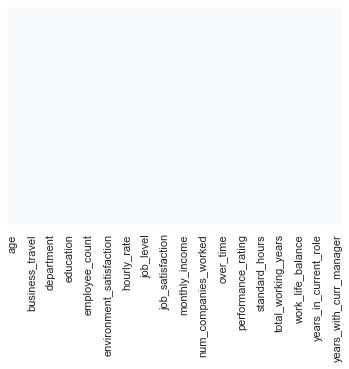

In [12]:
# Let's see if we have any missing data, luckily we don't!
_ = sns.heatmap(df_employee.isnull(), yticklabels=False, cbar=False, cmap='Blues')

## 2.6 Descriptive statistics

In [13]:
# creates a dataset for numerical attributes
num_attributes = df_employee.select_dtypes(include=['int64'])

# creates a dataset for categorical attributes
cat_attributes = df_employee.select_dtypes(exclude=['int64'])

In [14]:
# checks the operation
num_attributes.sample(2)

,age,daily_rate,distance_from_home,education,employee_count,employee_number,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
1439,36,557,3,3,1,2024,1,94,2,3,4,7644,12695,0,19,3,3,80,2,10,2,3,9,7,3,4
1440,36,688,4,2,1,2025,4,97,3,2,2,5131,9192,7,13,3,2,80,3,18,3,3,4,2,0,2


In [15]:
# checks the operation
cat_attributes.sample(2)

,attrition,business_travel,department,education_field,gender,job_role,marital_status,over18,over_time
760,No,Travel_Frequently,Sales,Marketing,Female,Sales Executive,Married,Y,No
345,No,Travel_Rarely,Research & Development,Life Sciences,Male,Research Scientist,Divorced,Y,No


In [16]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [17]:
# checking the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,age,18.0,60.0,42.0,36.923810,36.0,9.132266,0.413286,-0.404145
1,daily_rate,102.0,1499.0,1397.0,802.485714,802.0,403.371829,-0.003519,-1.203823
2,distance_from_home,1.0,29.0,28.0,9.192517,7.0,8.104107,0.958118,-0.224833
3,education,1.0,5.0,4.0,2.912925,3.0,1.023817,-0.289681,-0.559115
4,employee_count,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
5,employee_number,1.0,2068.0,2067.0,1024.865306,1020.5,601.819530,0.016574,-1.223179
6,environment_satisfaction,1.0,4.0,3.0,2.721769,3.0,1.092710,-0.321654,-1.202521
7,hourly_rate,30.0,100.0,70.0,65.891156,66.0,20.322512,-0.032311,-1.196398
8,job_involvement,1.0,4.0,3.0,2.729932,3.0,0.711319,-0.498419,0.270999
9,job_level,1.0,5.0,4.0,2.063946,2.0,1.106563,1.025401,0.399152


### 2.6.1 Categorical attributes

In [18]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

attrition          2
business_travel    3
department         3
education_field    6
gender             2
job_role           9
marital_status     3
over18             1
over_time          2
dtype: int64

# 3.0 Feature Engineering

### 3.0.1 Project checkpoint

In [19]:
# saves df_employee to df1
df1 = df_employee.copy()

## 3.1 Hypothesis mindmap

![](img/mind-map.jpg)

## 3.2 Creating hypotheses

### 3.2.1 Age

1. People up to 40s tend to leave.
2. People 40+ tend not to leave.

### 3.2.2 Education

1. People that have higher degree of education tend to leave.
2. People that have lower degree of education tend not to leave.

### 3.2.3 Distance from home

1. People who live far from work tend to leave.
2. People who live near work tend not to leave.

### 3.2.4 Marital status

1. Single people tend to leave.
2. Married people tend not to leave.

### 3.2.5 Overtime

1. People who make overtime tend to leave.
2. People who don't make overtime tend to stay.

### 3.2.6 Performance rating

1. People who present higher performance ratings tend to leave.
2. People who present lower performance ratings tend to leave.
3. People who present medium performance ratings tend not to leave.

### 3.2.7 Job level and role

1. People who have lower job level tend to leave.
2. People who have medium and higher job level tend not to leave.
3. People who weren't promoted for long time tend to leave.
4. People who are in the current role for long time tend to leave.

### 3.2.8 Job involvement

1. People who feel less involved with the job tend to leave.
2. People who feel more involved with the job tend not to leave.

### 3.2.9 Job satisfaction

1. People who feel less satisfied with the job tend to leave.
2. People who feel more satisfied with the job tend not to leave.

### 3.2.10 Environment satisfaction

1. People who feel less satisfied with the environment tend to leave.
2. People who feel more satisfied with the environment tend not to leave.

### 3.2.11 Work life balance

1. People who have lower work life balance tend to leave.
2. People who have higher work life balance tend not to leave.

### 3.2.12 Working years

1. People who professionally worked for more years tend to not leave.
2. People who worked at the same company for more years tend not to leave.
3. People who are job hoppers tend to leave.

### 3.2.13 Payment

1. People who are making more money tend not to leave.
2. People who have lower salary hike tend to leave.

### 3.2.11 Training

1. People who didn't receive training for long years tend to leave.
2. People who constantly received training tend not to leave.

### 3.2.12 Current manager

1. People who have been working for the same manager for short years tend to leave.
2. People who have been working for the same manager for long years tend not to leave.
3. People who have lower quality of relationship with the manager tend to leave.
4. People who have higher quality of relationship with the manager tend not to leave.

### 3.2.13 Business travel

1. People who travel more frequently tend to leave.
2. People who don't travel tend to stay.
3. People who travel less frequently tend to stay.

### Other questions that we need to answer

1. Which departments has more turnover?
2. Which education field has more turnover?

## 3.3 Chosen hypotheses

### Age
**H1.** People up to 40s tend to leave.

### Education
**H2.** People that have higher degree of education tend to leave more.

### Distance from home
**H3.** People who live far from work tend to leave.

### Marital status
**H4.** Single people tend to leave.

### Overtime
**H5.** People who make overtime tend to leave more.

### Performance rating
**H6.**	People who present higher performance ratings tend to leave more.

**H7.**	People who present lower performance ratings tend to leave more.

### Job level and role
**H8.**	People who have lower job level tend to leave more.

**H9.**	People who weren't promoted for long time tend to leave more.

**H10.** People who are in the current role for long time tend to leave more.

### Job involvement
**H11.** People who feel less involved with the job tend to leave more.

### Job satisfaction
**H12.** People who feel less satisfied with the job tend to leave more.

### Environment satisfaction
**H13.** People who feel less satisfied with the environment tend to leave more.

### Work life balance
**H14.** People who have lower work life balance tend to leave more.

### Working years
**H15.** People who professionally worked for more years tend to not leave.

**H16.** People who worked at the same company for more years tend not to leave.

**H17.** People who are job hoppers tend to leave.

### Payment
**H18.** People who are making more money tend not to leave.

**H19.** People who have lower salary hike tend to leave.

### Training
**H20.** People who didn't receive training for long years tend to leave more.

### Current manager
**H21.** People who have been working for the same manager for short years tend to leave more.

**H22.** People who have lower quality of relationship with the manager tend to leave more.

### Business travel
**H23.** People who travel more frequently tend to leave more.

### Other questions that we need to answer
**H24.** Which departments has more turnover?

**H25.** Which education field has more turnover?

## 3.3 Column filtering

We're going to drop the columns `over18` and `standard_hours` because every employee are over 18 years and have the same standard hours.

In addition, we're dropping `employee_count` and `employee_number` because the first is the same for all employees and the second is the equivalent to employee Id which don't make sense to keep for our analysis and predictions.

In [20]:
# cols to drop
cols_drop = ['over18', 'standard_hours', 'employee_count', 'employee_number']

# drops the columns
df1 = df1.drop(cols_drop, axis=1)

In [21]:
df1.sample()

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
465,46,No,Travel_Frequently,1034,Research & Development,18,1,Medical,1,Female,86,3,3,Healthcare Representative,3,Married,10527,8984,5,No,11,3,4,0,28,3,2,2,2,1,2


# 4.0 Exploratory data analysis

### 4.0.1 Project checkpoint

In [22]:
# saves progress
df2 = df1.copy()

## 4.1 Univariate analysis

In [23]:
# Let's replace 'Attrition' , 'overtime' , 'Over18' column with integers before performing any visualizations 
df2['over_time'] = df2['over_time'].apply(lambda x: 1 if x == 'Yes' else 0)
df2['attrition'] = df2['attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

### 4.1.1 Target variable

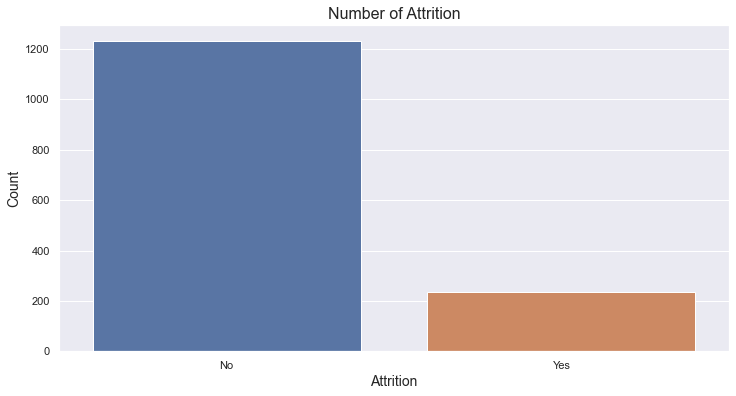

In [24]:
# plots count
ax = sns.countplot(df2['attrition'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("Number of Attrition", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Attrition", fontsize=14)

# set xticks labels
plt.xticks([0, 1], ['No', 'Yes'])

# displays plot
plt.show()

As observed, there are much more people that stayed than left the company.

In [25]:
# separating the data set for easier analysis
df_left = df2[df2['attrition'] == 1]
df_stayed = df2[df2['attrition'] == 0]

In [26]:
# Count the number of employees who stayed and left
# It seems that we are dealing with an imbalanced dataset 
total_employees_left = df_left.shape[0]
total_employees_stayed = df_stayed.shape[0]
total_employees = df2.shape[0]

print('Number of employees who left:', total_employees_left)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_left/total_employees)*100))

print('\nNumber of employees who stayed:', total_employees_stayed)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_stayed/total_employees)*100))

Number of employees who left: 237
This is equivalent to 16.12% of the total employees

Number of employees who stayed: 1233
This is equivalent to 83.88% of the total employees


### 4.1.2 Numerical variables

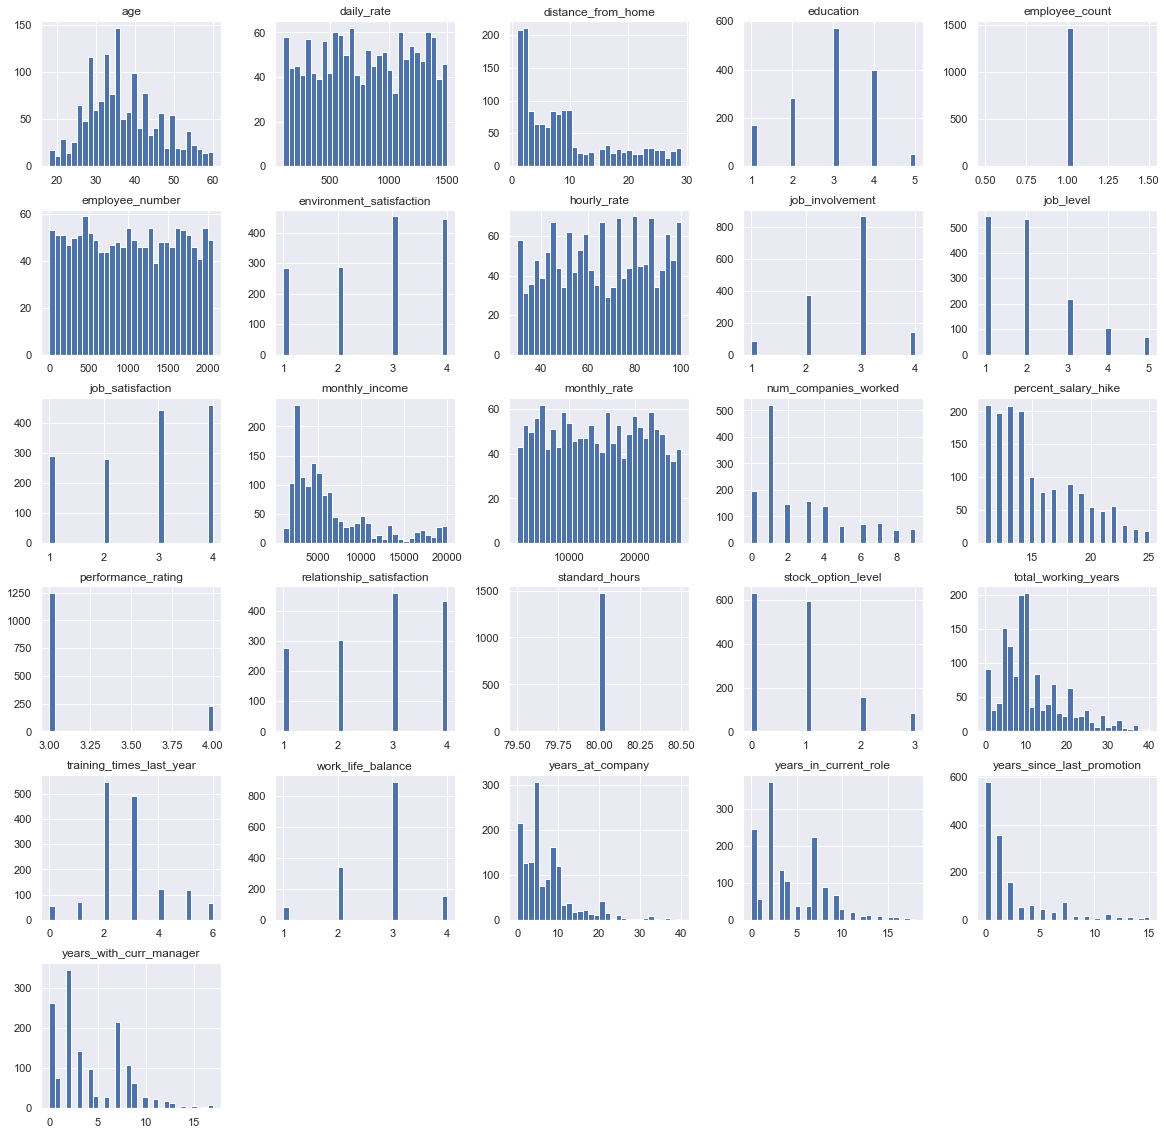

In [27]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

### 4.1.3 Categorical variables

In [28]:
cat_attributes

,attrition,business_travel,department,education_field,gender,job_role,marital_status,over18,over_time
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
1466,No,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No
1467,No,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes
1468,No,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No


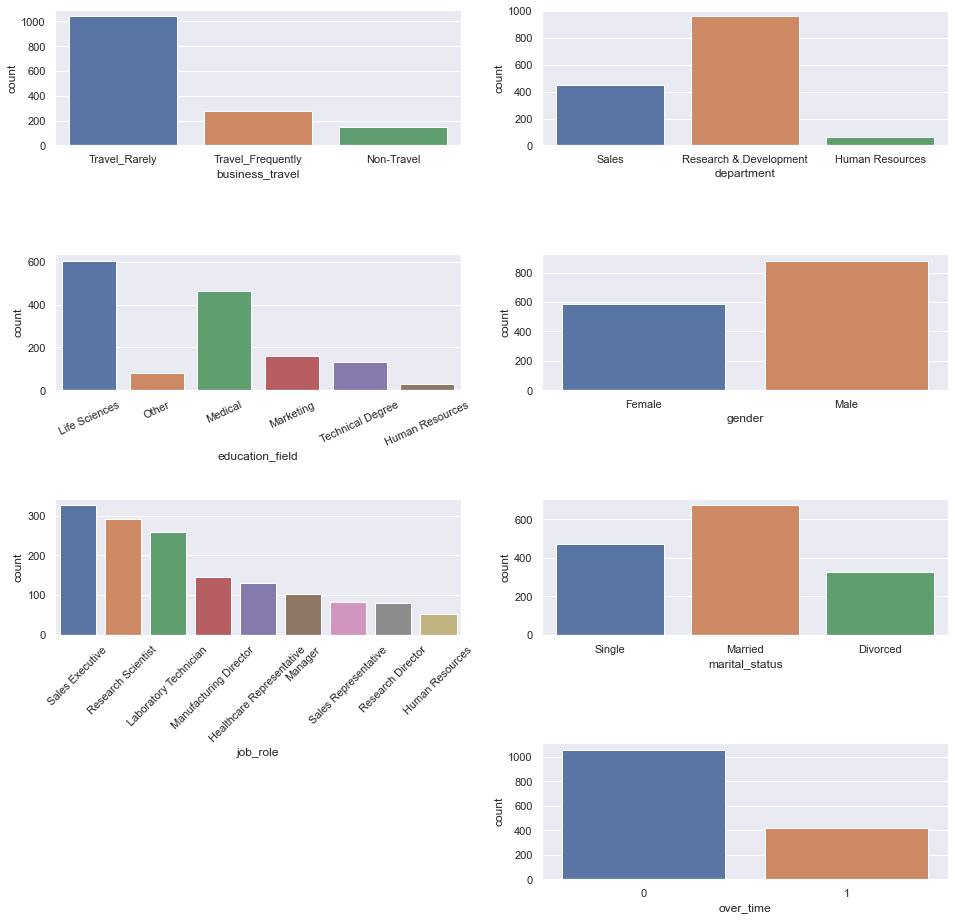

In [29]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# business_travel
plt.subplot(4, 2, 1)
sns.countplot(df2['business_travel'])

# department
plt.subplot(4, 2, 2)
sns.countplot(df2['department'])

# education_field
plt.subplot(4, 2, 3)
sns.countplot(df2['education_field'])
plt.xticks(rotation=25)

# gender
plt.subplot(4, 2, 4)
sns.countplot(df2['gender'])

# job_role
plt.subplot(4, 2, 5)
sns.countplot(df2['job_role'])
plt.xticks(rotation=45)

# marital_status
plt.subplot(4, 2, 6)
sns.countplot(df2['marital_status'])

# over_time
plt.subplot(4, 2, 8)
sns.countplot(df2['over_time'])

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.8)

# display plots
plt.show()

## 4.2 Bivariate analysis

### H1. People up to 40s tend to leave.

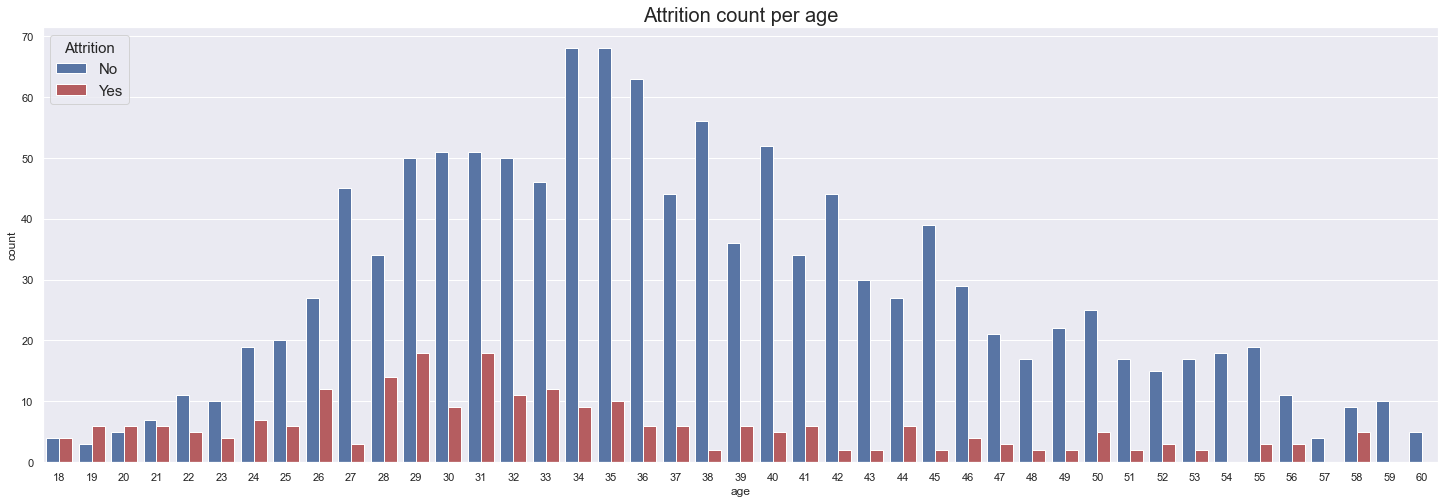

In [30]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='age', hue='attrition', data=df2, palette=["b", "r"])

# sets plot title
ax.set_title("Attrition count per age", fontsize=20)

# sets the legend
plt.legend(title="Attrition", labels=['No', 'Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

Although, up to 22 years old, comparing people who do tend to leave with who don't, the proportion of people who do tend to leave is large. In addition, it seems that people in young ages (up to 40s) tend to leave more than people in elder ages (40+). 

> Thus, the hypothesis is **TRUE**.

### H2. People that have higher degree of education tend to leave more.

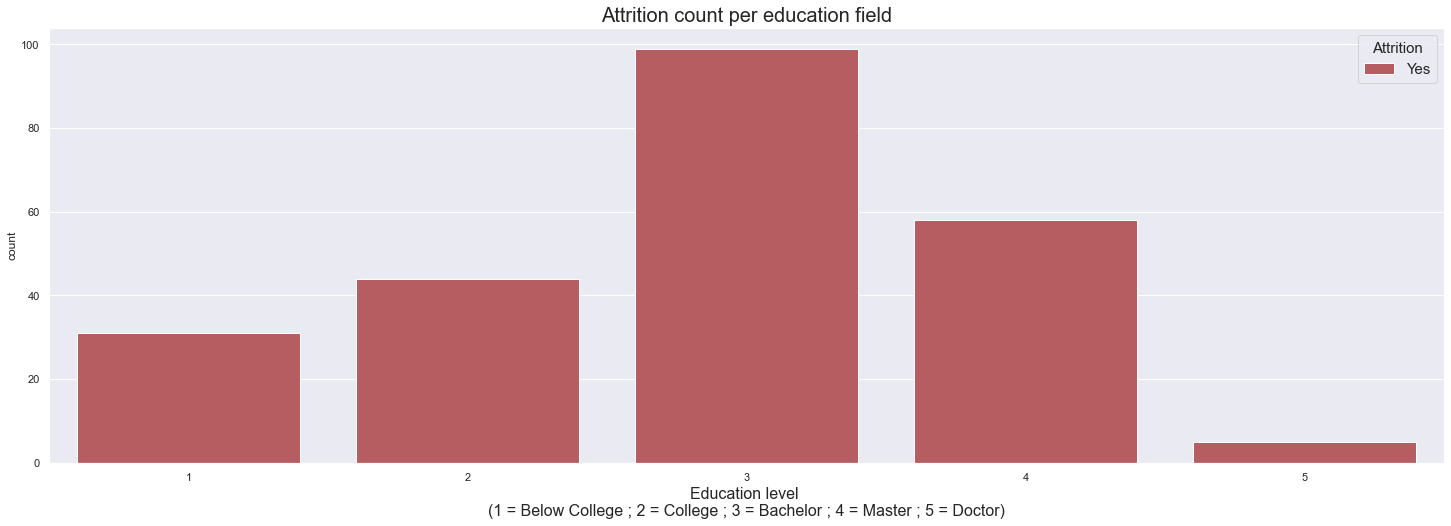

In [31]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='education', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per education field", fontsize=20)

# sets xlabel
plt.xlabel('Education level \n(1 = Below College ; 2 = College ; 3 = Bachelor ; 4 = Master ; 5 = Doctor)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people that have higher degree (**masters and doctors**) of education tend **not to leave** compared to people that have other degrees.

> Thus, the hypothesis is **FALSE**.

### H3. People who live far from work tend to leave.

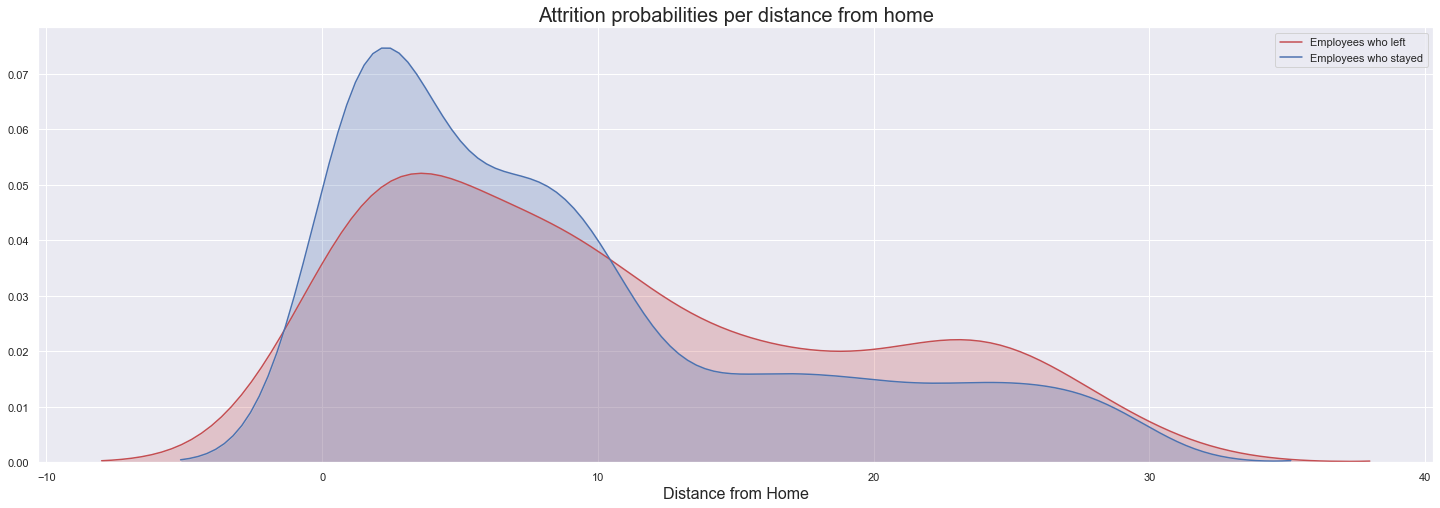

In [32]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
sns.kdeplot(df_left['distance_from_home'], label='Employees who left', shade=True, color='r')
sns.kdeplot(df_stayed['distance_from_home'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per distance from home", fontsize=20)

# sets x label
plt.xlabel('Distance from Home', fontsize=16)

# displays the plot
plt.show()

Observing the plots, as the distance gets higher, between 12 and 28, the tendency for an employee to leave is higher.

> Thus, the hypothesis is **TRUE**.

### H4. Single people tend to leave more.

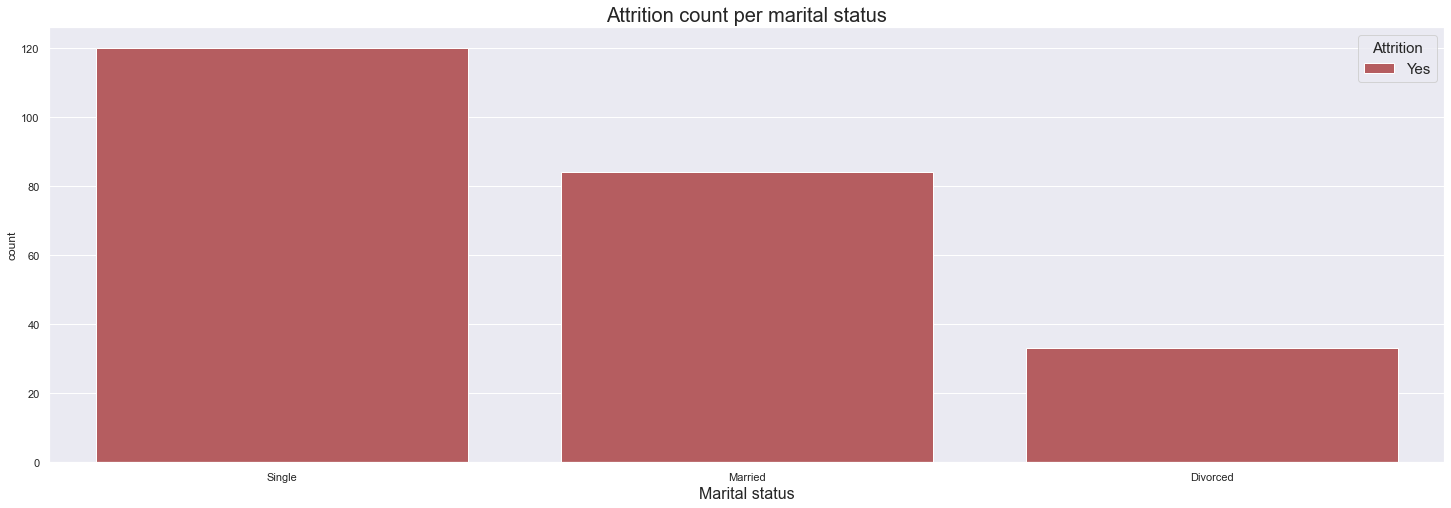

In [33]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='marital_status', hue='attrition', data=df_left, palette=['r'],
             order=df_left['marital_status'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per marital status", fontsize=20)

# sets xlabel
plt.xlabel('Marital status', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in general, people tend to stay, independently of their marital status. However, single people tend to leave more than married.

> Thus, the hypothesis is **TRUE**.

### H5. People who make overtime tend to leave more.

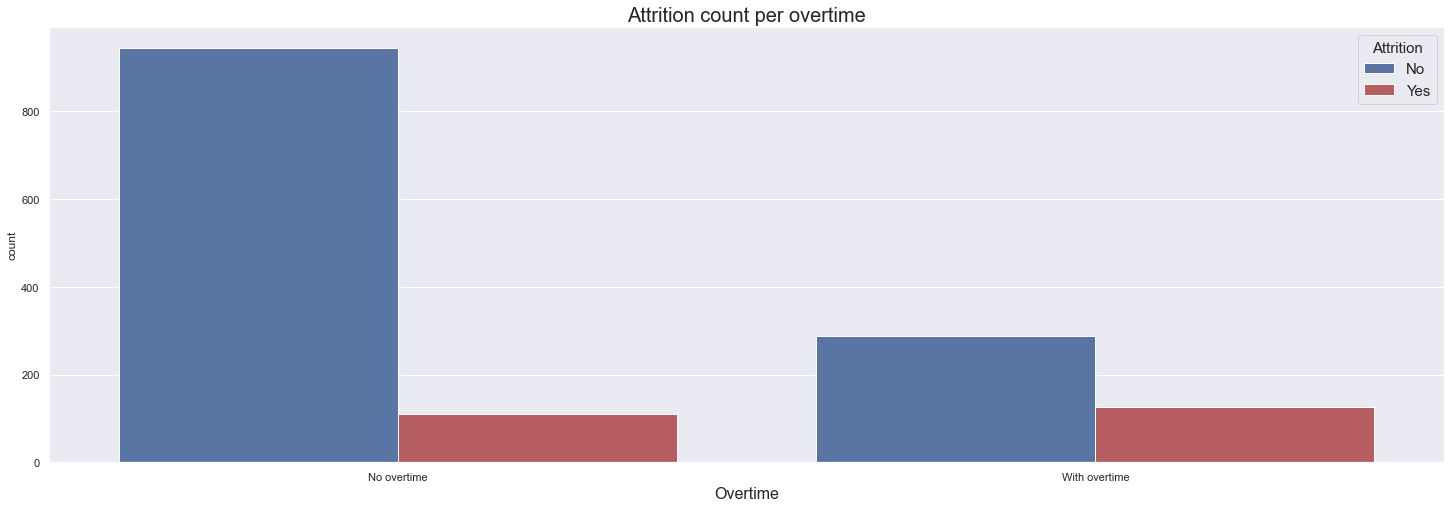

In [34]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='over_time', hue='attrition', data=df2, palette=["b", "r"])

# sets plot title
ax.set_title("Attrition count per overtime", fontsize=20)

# sets xlabel
plt.xlabel('Overtime', fontsize=16)

# sets xticks labels
plt.xticks([0, 1], ['No overtime','With overtime'])

# sets the legend
plt.legend(title="Attrition", labels=['No', 'Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in general, people tend to stay even when making overtime. However, they tend to stay far less when making than when not making.

> Thus, the hypothesis is **TRUE**.

### H6. People who present higher performance ratings tend to leave more.
### H7. People who present lower performance ratings tend to leave more.

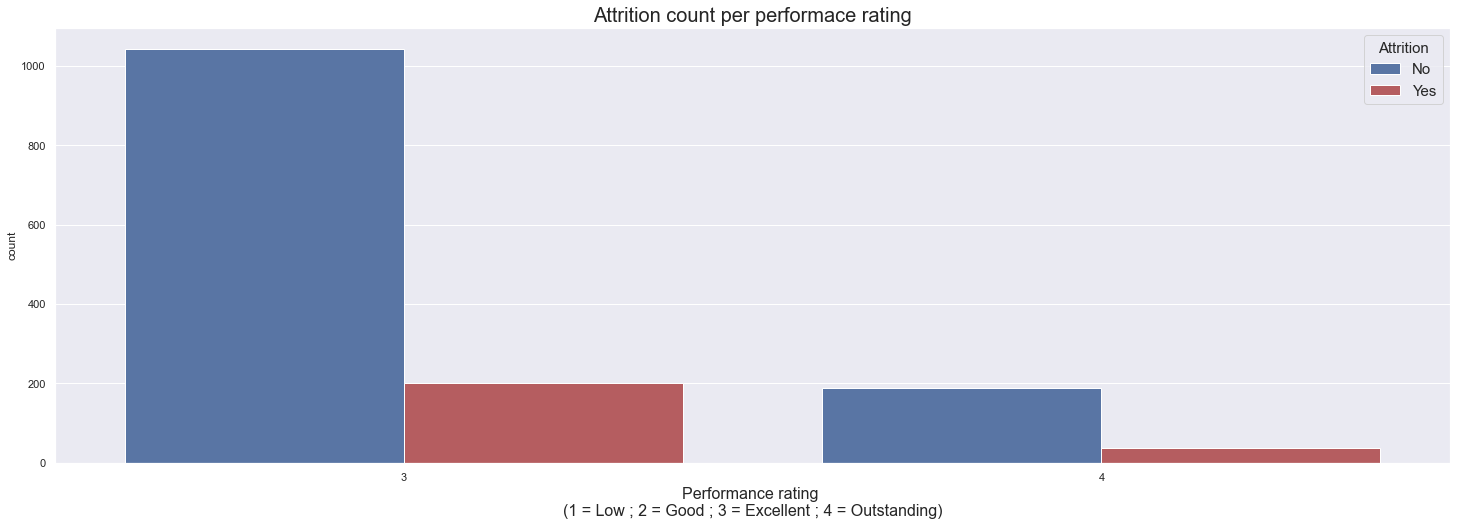

In [35]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='performance_rating', hue='attrition', data=df2, palette=["b", "r"])

# sets plot title
ax.set_title("Attrition count per performace rating", fontsize=20)

# sets xlabel
plt.xlabel('Performance rating \n(1 = Low ; 2 = Good ; 3 = Excellent ; 4 = Outstanding)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['No', 'Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, in the data set there is only ratings for `Excellent` and `Outstanding`. Thus, we can only validate **H6**. So, in general, people presenting high performance ratings tend to stay. However, people who presents `Outstanding` performance ratings tend to stay far less.

> Thus, the hypothesis H7 is **TRUE** and H6 is **FALSE**.

### H8. People who have lower job level tend to leave more.

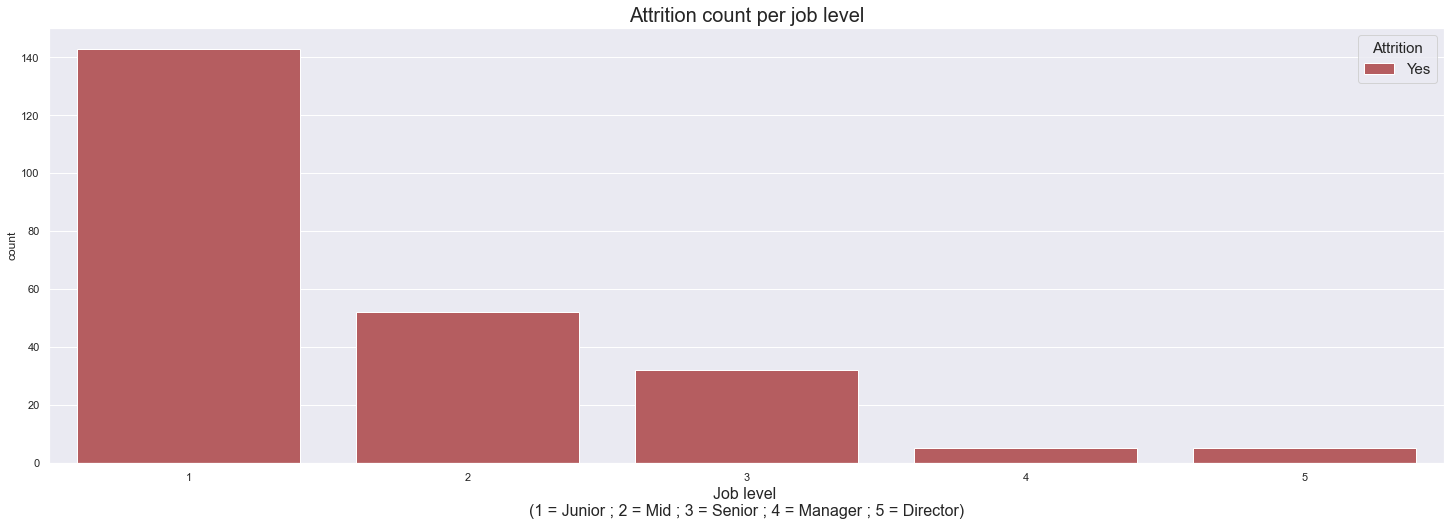

In [36]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_level', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job level", fontsize=20)

# sets xlabel
plt.xlabel('Job level \n(1 = Junior ; 2 = Mid ; 3 = Senior ; 4 = Manager ; 5 = Director)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower job level (`junior` and `mid`) compared to others tend to leave more.

> Thus, the hypothesis is **TRUE**.

### H9. People who weren't promoted for long time tend to leave more.

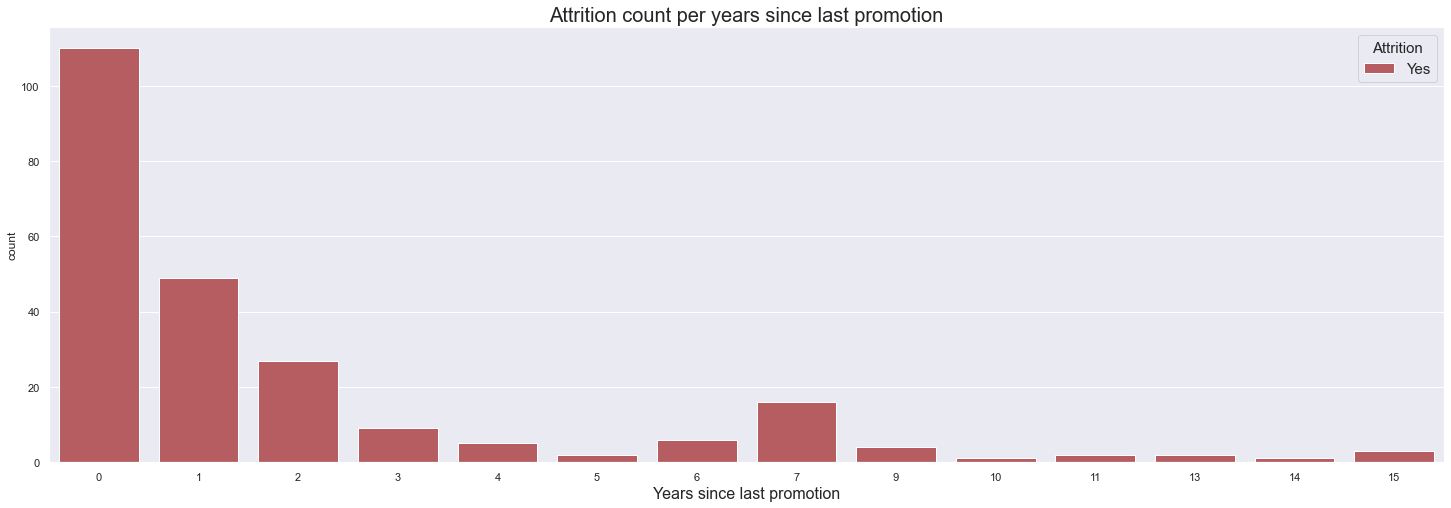

In [37]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='years_since_last_promotion', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years since last promotion", fontsize=20)

# sets xlabel
plt.xlabel('Years since last promotion', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who weren't promoted for long time **tend to leave far less** than those who had their last promotion up to 3 years.

> Thus, the hypothesis is **FALSE**.

### H10. People who are in the current role for long time tend to leave more.

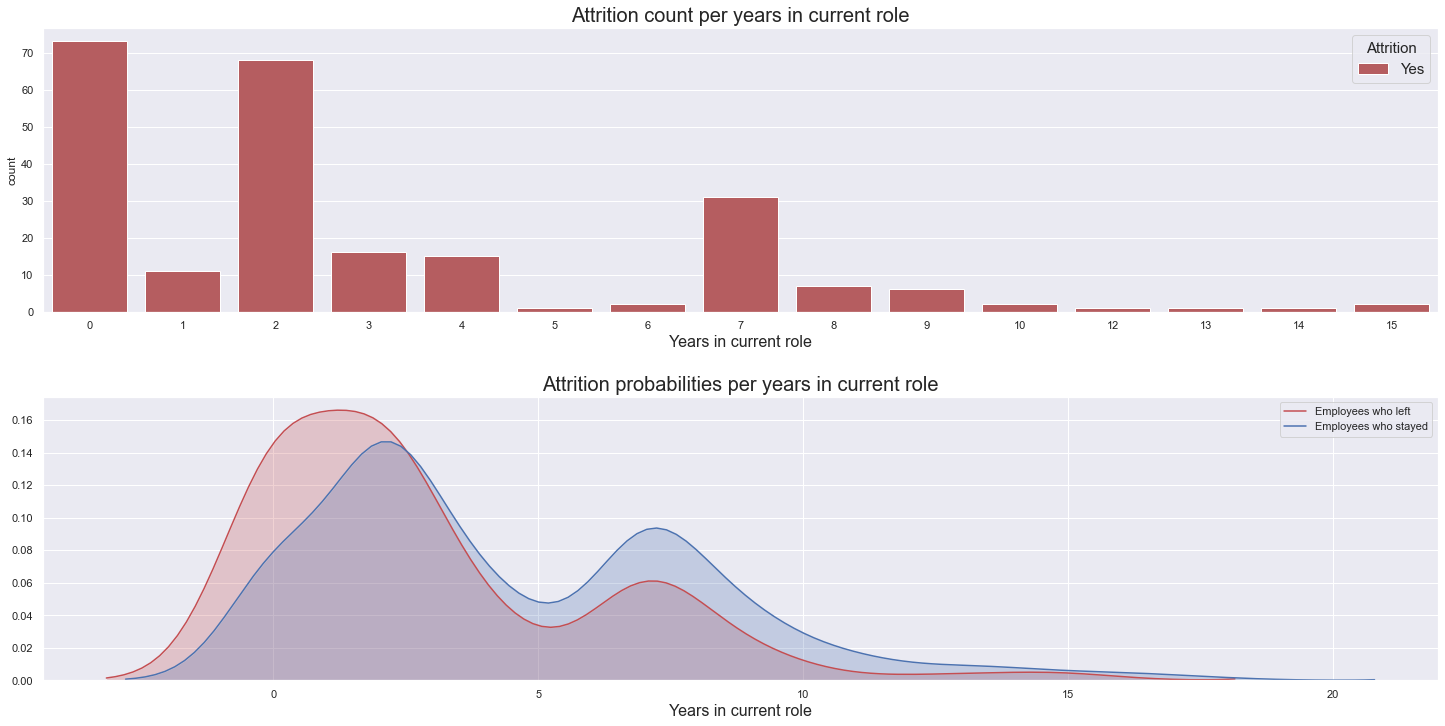

In [38]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_in_current_role', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years in current role", fontsize=20)

# sets xlabel
plt.xlabel('Years in current role', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_in_current_role'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_in_current_role'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per years in current role", fontsize=20)

# sets x label
plt.xlabel('Years in current role', fontsize=16)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who are in the current role for long time tend **not to leave**. We can ser a peak for those in the early years in current role, specifically on their first months and second year.

> Thus, the hypothesis is **FALSE**.

### H11. People who feel less involved with the job tend to leave more.

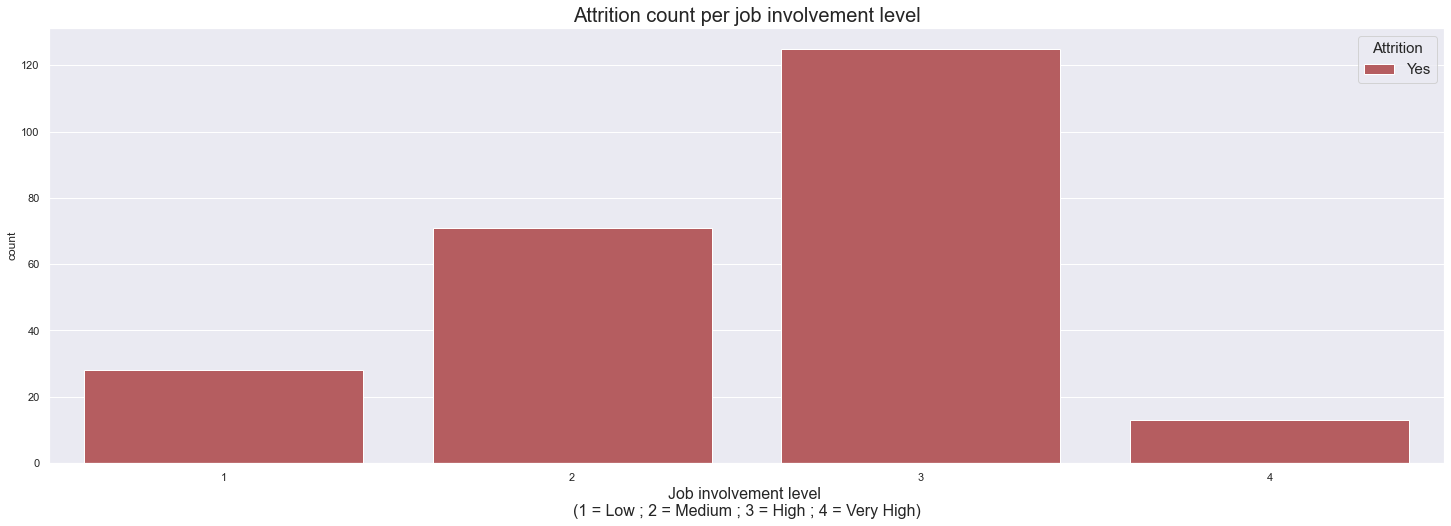

In [39]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_involvement', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job involvement level", fontsize=20)

# sets xlabel
plt.xlabel('Job involvement level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who feel less involved with the job **don't tend to leave more**.

> Thus, the hypothesis is **FALSE**.

### H12. People who feel less satisfied with the job tend to leave more.

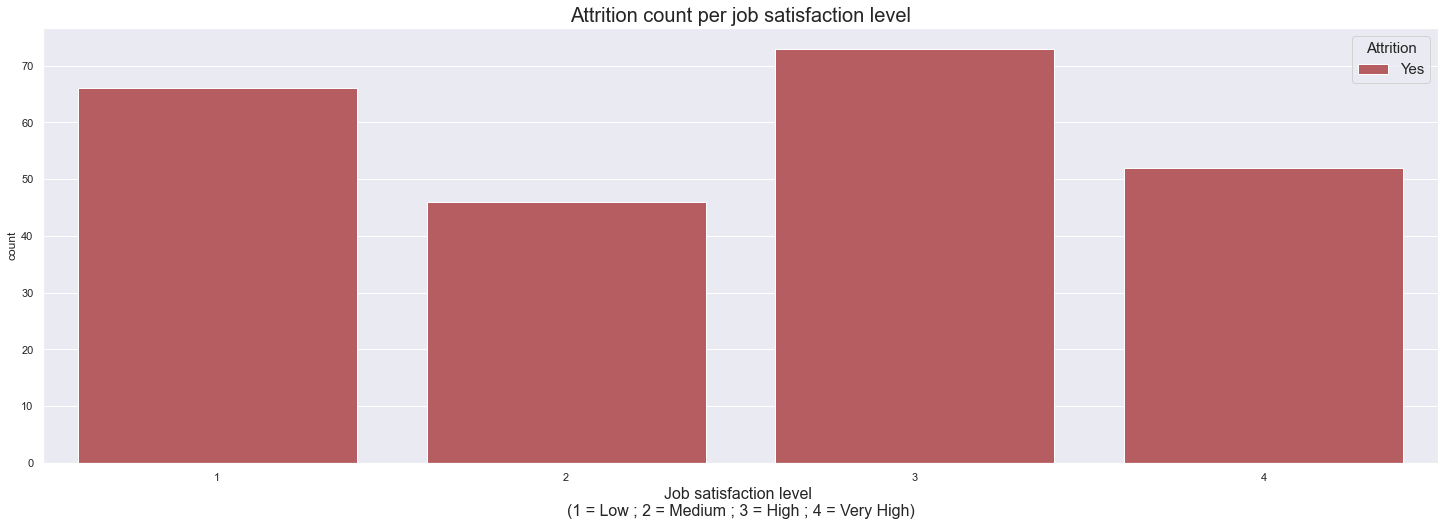

In [40]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='job_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per job satisfaction level", fontsize=20)

# sets xlabel
plt.xlabel('Job satisfaction level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who feel less satisfied with the job **don't tend to leave more**.

> Thus, the hypothesis is **FALSE**.

### H13. People who feel less satisfied with the environment tend to leave more.

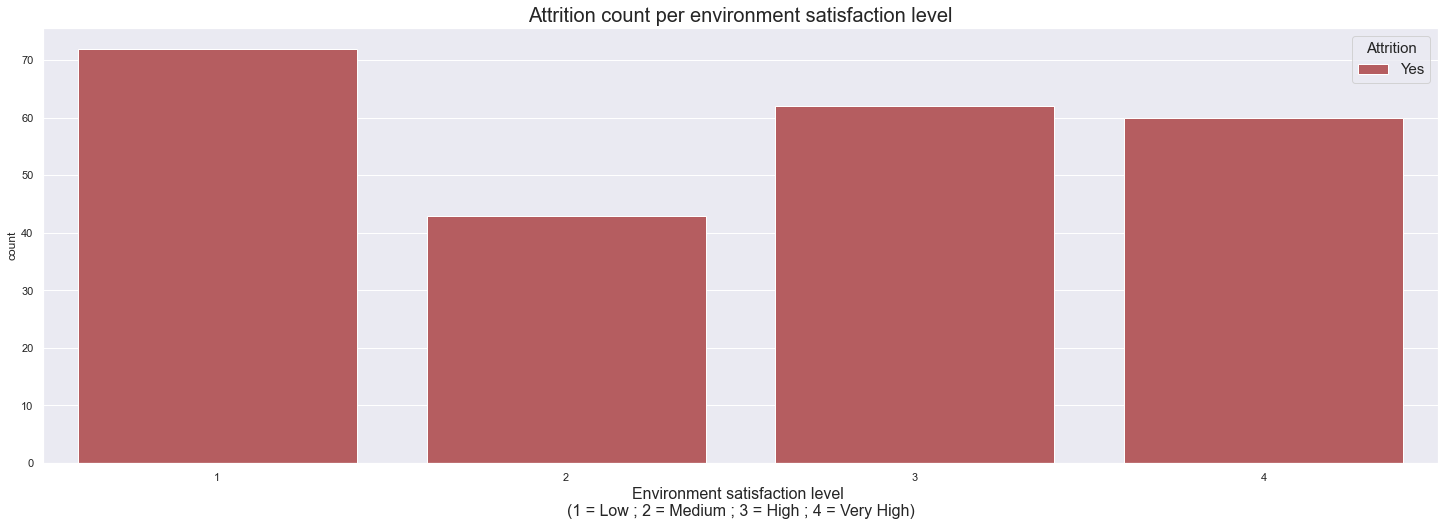

In [41]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='environment_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per environment satisfaction level", fontsize=20)

# sets xlabel
plt.xlabel('Environment satisfaction level \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, we can't really say if people who feel less satisfied with the environment tend to leave more, because the counts are almost equal for each level of satisfaction.

### H14. People who have lower work life balance tend to leave more.

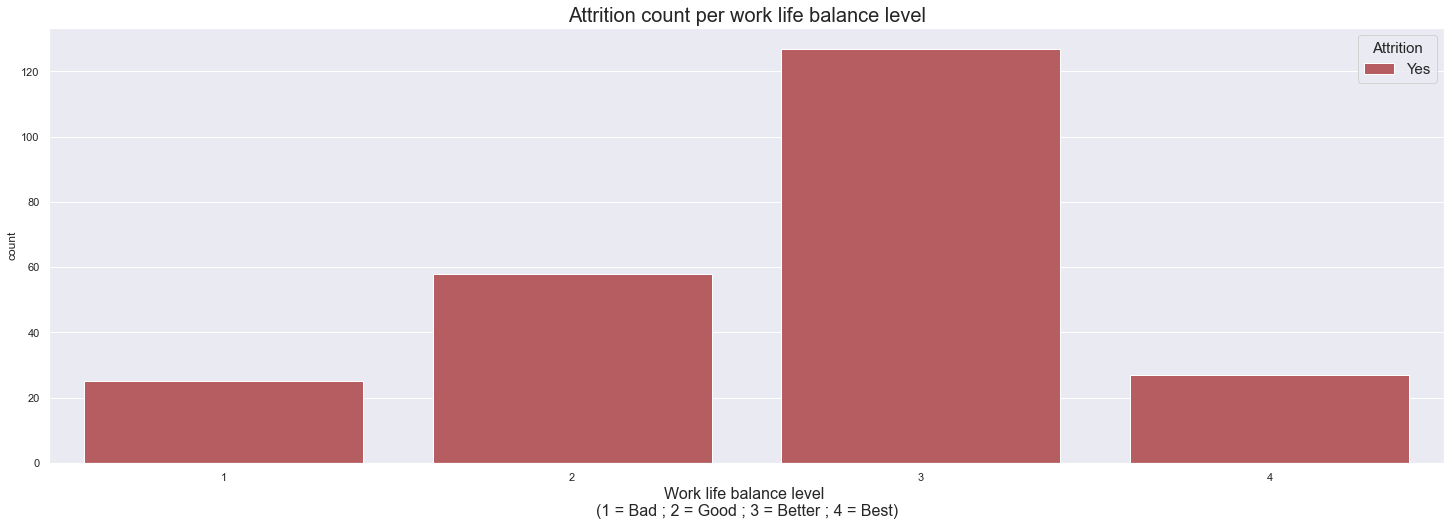

In [42]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='work_life_balance', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per work life balance level", fontsize=20)

# sets xlabel
plt.xlabel('Work life balance level \n(1 = Bad ; 2 = Good ; 3 = Better ; 4 = Best)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower work life balance **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H15. People who professionally worked for more years tend to not leave.

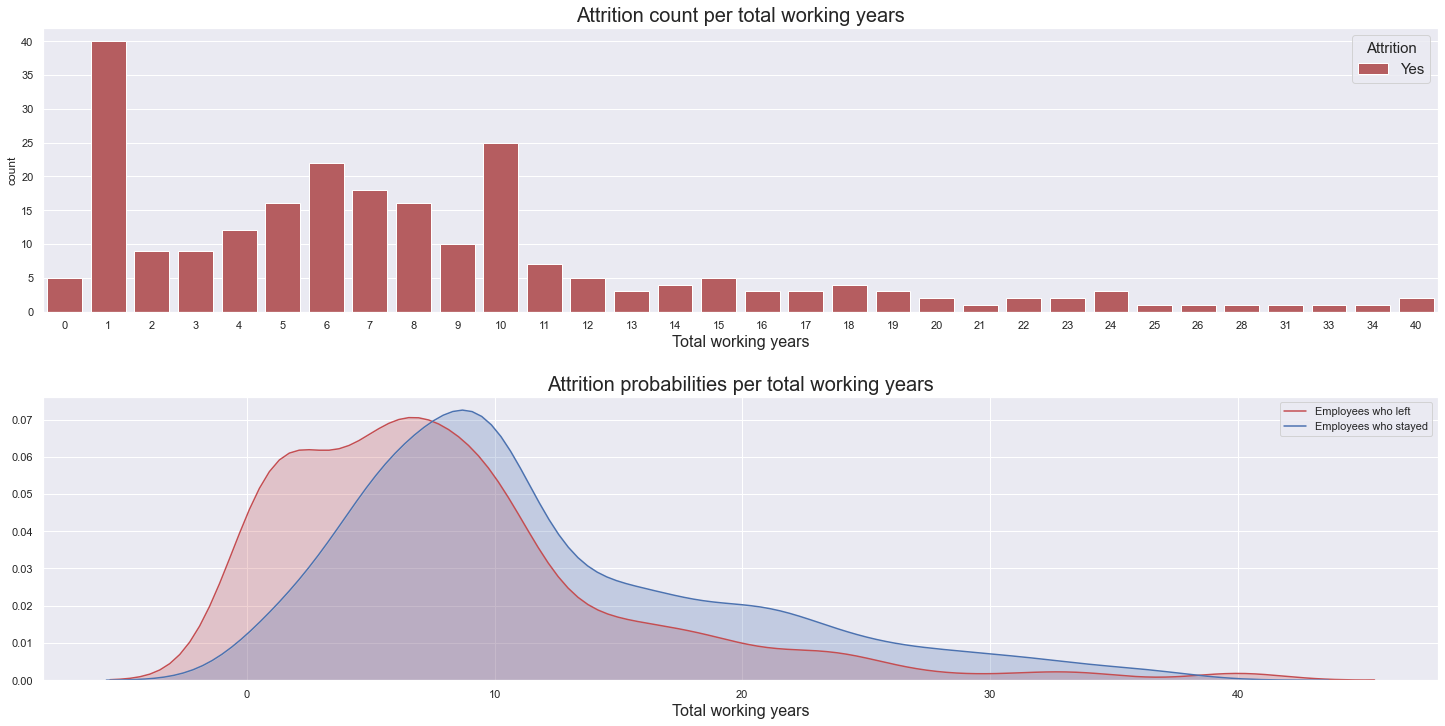

In [43]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='total_working_years', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per total working years", fontsize=20)

# sets xlabel
plt.xlabel('Total working years', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['total_working_years'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['total_working_years'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per total working years", fontsize=20)

# sets x label
plt.xlabel('Total working years', fontsize=16)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who professionally worked for more years **tend to not leave**. In addition, up to 10 years working professionally, people tend to leave more.

> Thus, the hypothesis is **TRUE**.

### H16. People who worked at the same company for more years tend not to leave.

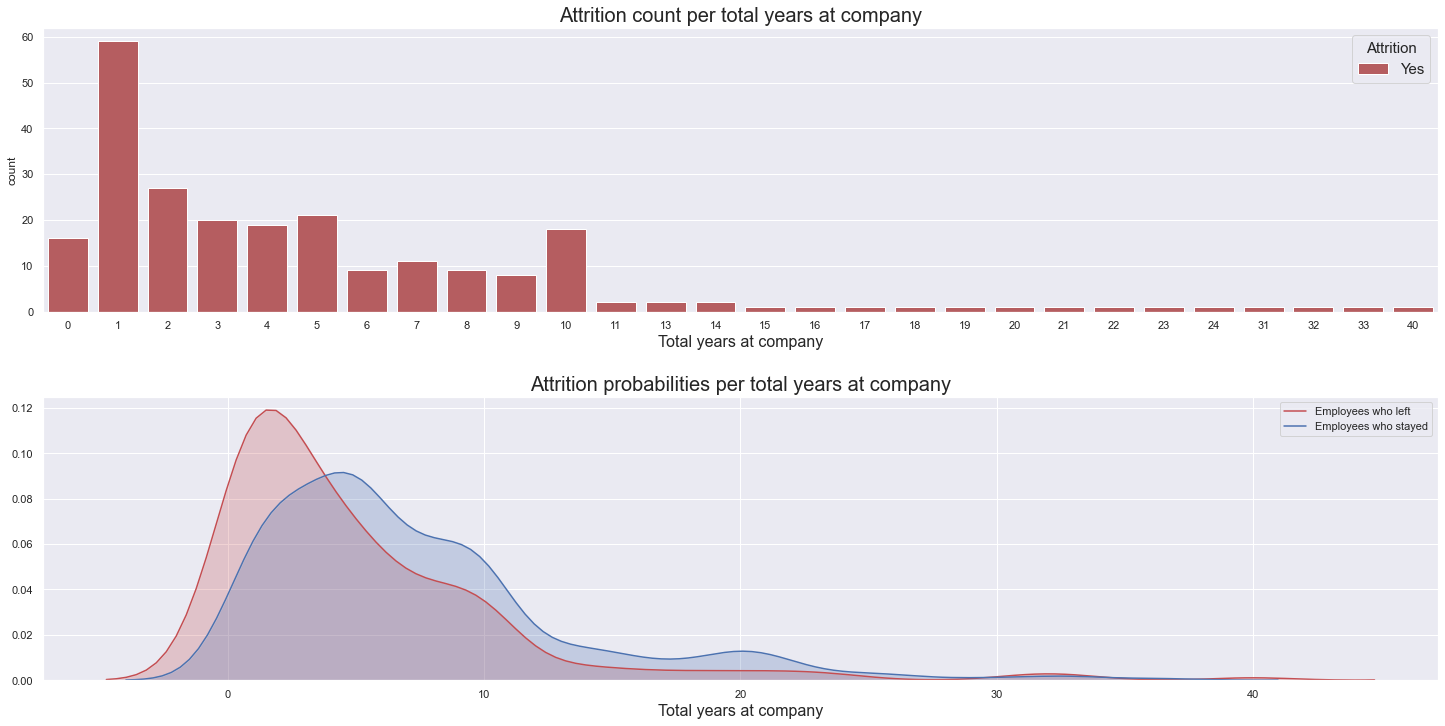

In [44]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_at_company', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per total years at company", fontsize=20)

# sets xlabel
plt.xlabel('Total years at company', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_at_company'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_at_company'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per total years at company", fontsize=20)

# sets x label
plt.xlabel('Total years at company', fontsize=16)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who worked at the same company for more years **tend not to leave**.

> Thus, the hypothesis is **TRUE**.

### H17. People who are job hoppers tend to leave more.

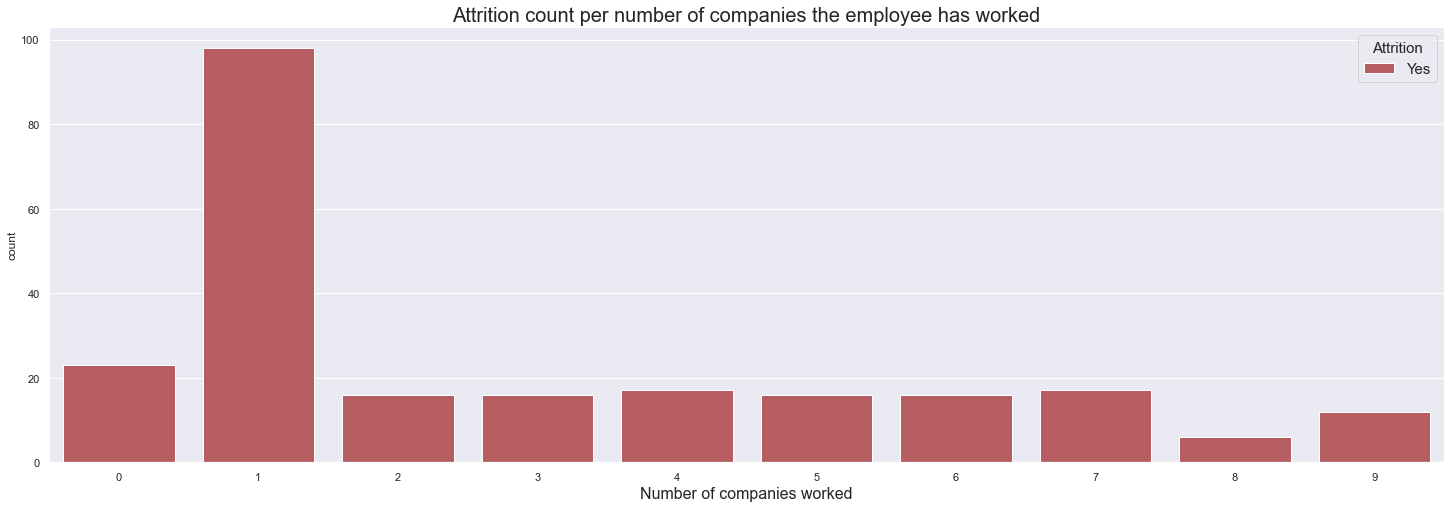

In [45]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='num_companies_worked', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per number of companies the employee has worked", fontsize=20)

# sets xlabel
plt.xlabel('Number of companies worked', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who are job hoppers **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H18. People who are making more money tend not to leave.

In [46]:
# separates data
df_leaves_hourly_rate = df2[['attrition','hourly_rate']]
df_leaves_daily_rate = df2[['attrition','daily_rate']]
df_leaves_monthly_rate = df2[['attrition','monthly_rate']]

# converts to categorical
df_leaves_hourly_rate['attrition'] = df_leaves_hourly_rate['attrition'].astype('category')
df_leaves_daily_rate['attrition'] = df_leaves_daily_rate['attrition'].astype('category')
df_leaves_monthly_rate['attrition'] = df_leaves_monthly_rate['attrition'].astype('category')

/Users/brunokatekawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/brunokatekawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/brunokatekawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

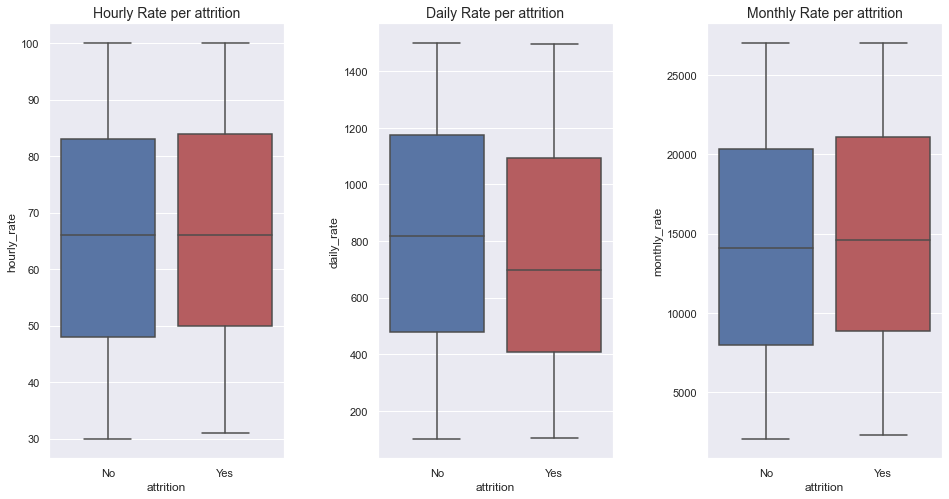

In [47]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.boxplot(x='attrition', y='hourly_rate',  palette=['b', 'r'], data=df_leaves_hourly_rate)
ax.set_title("Hourly Rate per attrition", fontsize=14)
plt.xticks([0, 1], ['No', 'Yes'])

# plots a scatter plot
plt.subplot(1, 3, 2)
ax = sns.boxplot(x='attrition', y='daily_rate',  palette=['b', 'r'], data=df_leaves_daily_rate)
ax.set_title("Daily Rate per attrition", fontsize=14)
plt.xticks([0, 1], ['No', 'Yes'])

# plots a scatter plot
plt.subplot(1, 3, 3)
ax = sns.boxplot(x='attrition', y='monthly_rate',  palette=['b', 'r'], data=df_leaves_monthly_rate)
ax.set_title("Monthly Rate per attrition", fontsize=14)
plt.xticks([0, 1], ['No', 'Yes'])

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.4)

# displays the plots
plt.show()

As observed, people who are daily making more money tend to stay. As the median for hourly rate and monthly rate are quite similar.

> Thus, the hypothesis is **TRUE**.

### H19. People who have shorter salary hike range tend to leave.

In [48]:
# separates data
df_leaves_salary_hike = df2[['attrition','percent_salary_hike']]

# converts to categorical
df_leaves_salary_hike['attrition'] = df_leaves_salary_hike['attrition'].astype('category')

/Users/brunokatekawa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


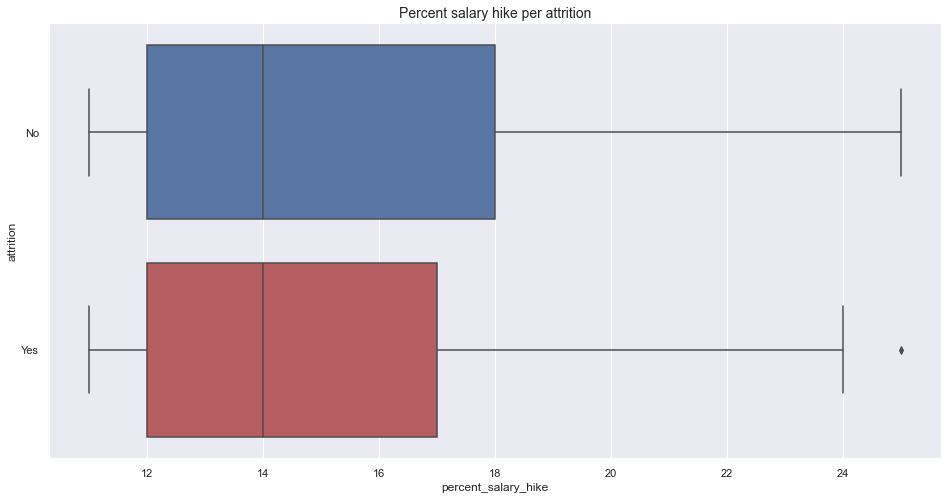

In [49]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
ax = sns.boxplot(x='percent_salary_hike', y='attrition', palette=['b', 'r'], data=df_leaves_salary_hike)
ax.set_title("Percent salary hike per attrition", fontsize=14)
plt.yticks([0, 1], ['No', 'Yes'])


# displays the plots
plt.show()

As observed, people who have shorter salary hike range **tend to leave**.

> Thus, the hypothesis is **TRUE**.

### H20. People who received less training last year tend to leave more.

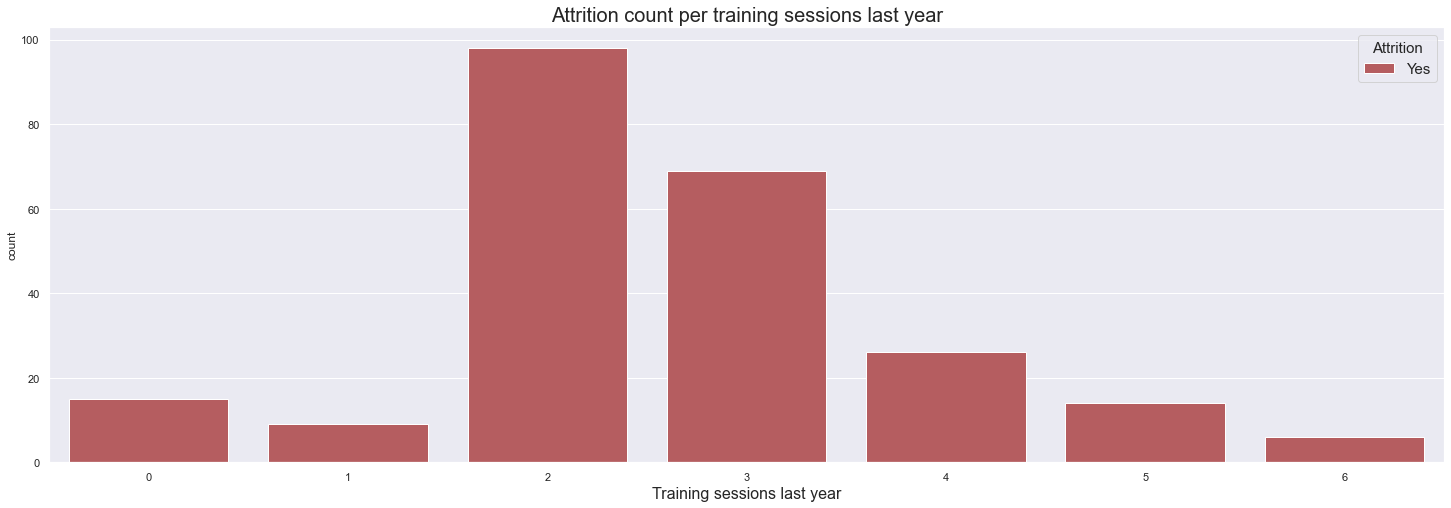

In [50]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='training_times_last_year', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per training sessions last year", fontsize=20)

# sets xlabel
plt.xlabel('Training sessions last year', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

People who received few and many training sessions last year **tend to stay**. However, people who are in the middle tend to leave.

### H21. People who have been working for the same manager for short years tend to leave more.

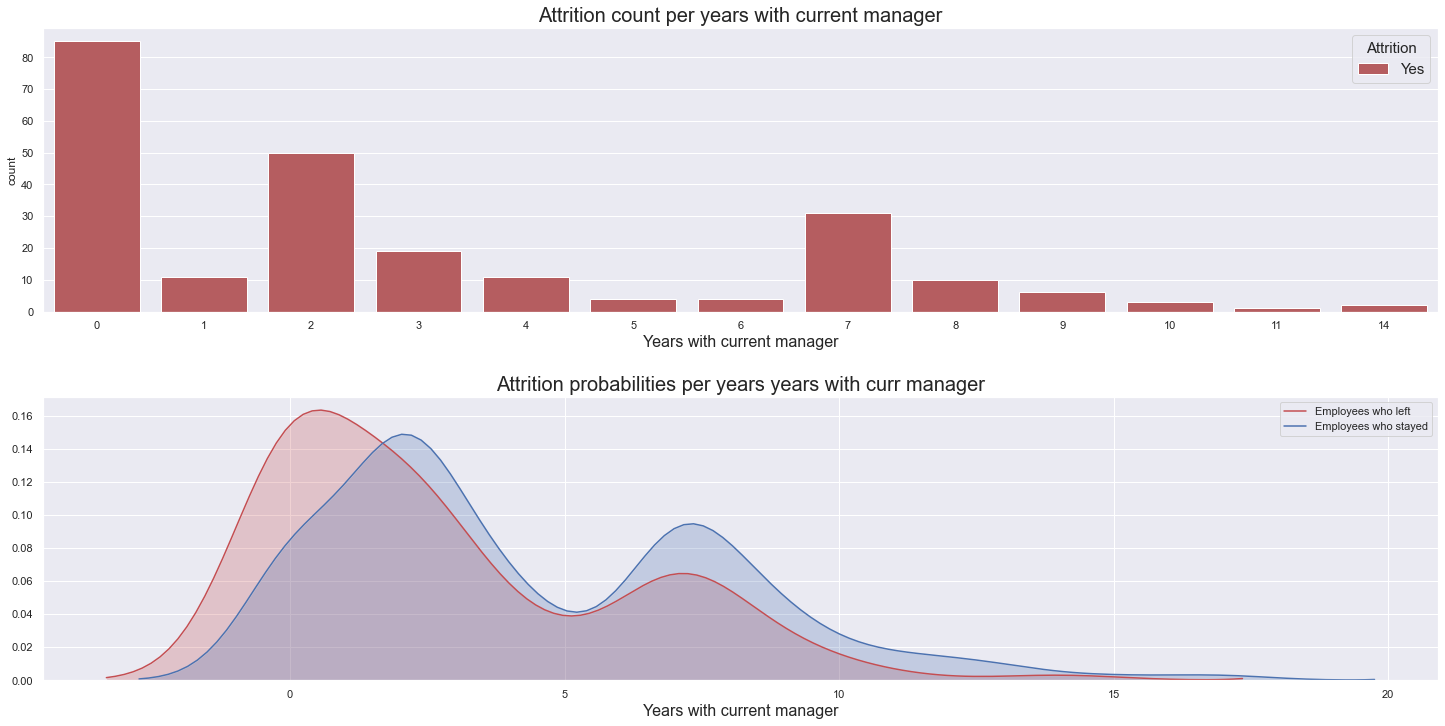

In [51]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 12)

# plots the graph
plt.subplot(2,1,1)
ax = sns.countplot(x='years_with_curr_manager', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per years with current manager", fontsize=20)

# sets xlabel
plt.xlabel('Years with current manager', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
plt.subplot(2,1,2)
ax = sns.kdeplot(df_left['years_with_curr_manager'], label='Employees who left', shade=True, color='r')
ax = sns.kdeplot(df_stayed['years_with_curr_manager'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("Attrition probabilities per years years with curr manager", fontsize=20)

# sets x label
plt.xlabel('Years with current manager', fontsize=16)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.3)

# display plots
plt.show()

As observed, people who have been working for the same manager for short years **tend to leave more**.

> Thus, the hypothesis is **TRUE**.

### H22. People who have lower quality of relationship with the manager tend to leave more.

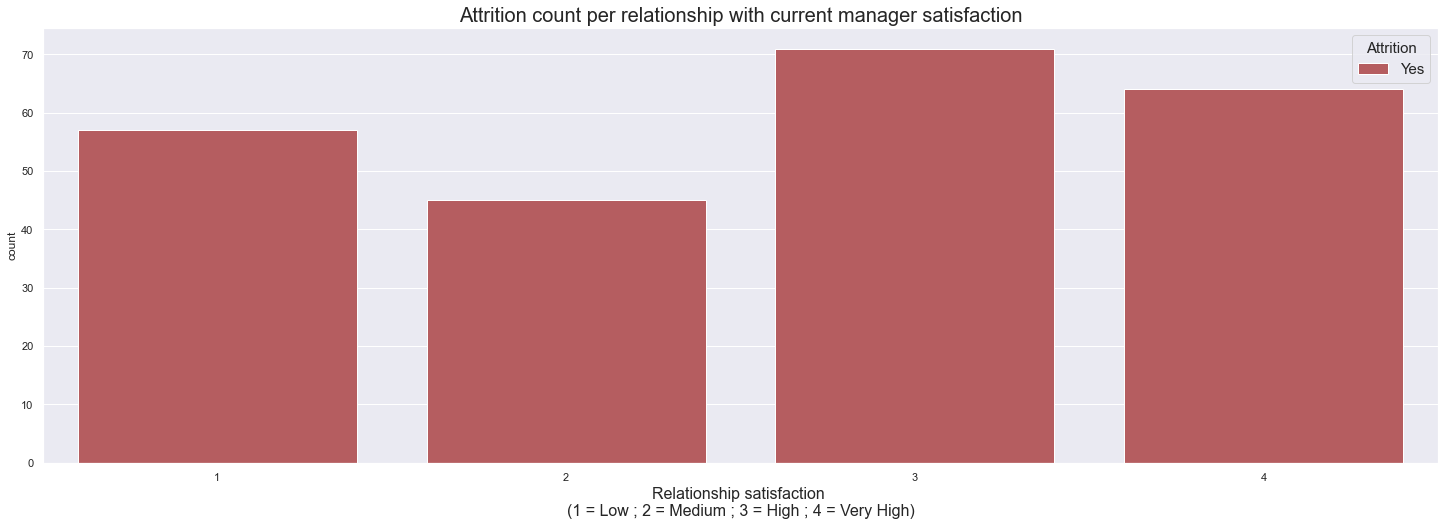

In [52]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='relationship_satisfaction', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per relationship with current manager satisfaction", fontsize=20)

# sets xlabel
plt.xlabel('Relationship satisfaction \n(1 = Low ; 2 = Medium ; 3 = High ; 4 = Very High)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who have lower quality of relationship with the manager **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H23. People who travel more frequently tend to leave more.

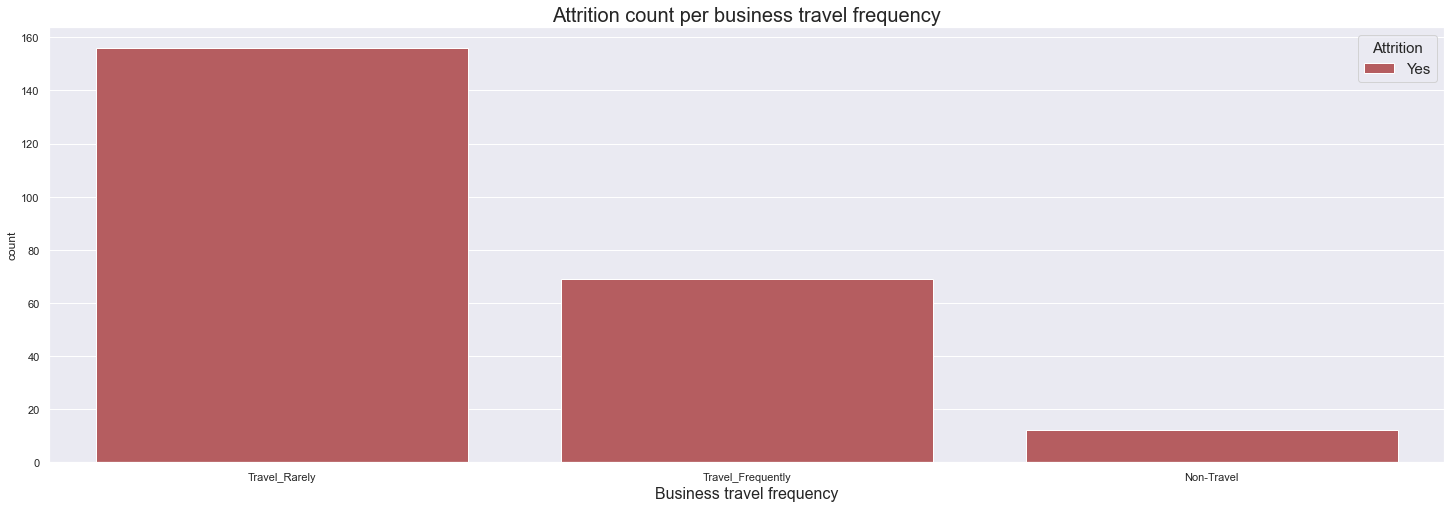

In [53]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='business_travel', hue='attrition', data=df_left, palette=['r'])

# sets plot title
ax.set_title("Attrition count per business travel frequency", fontsize=20)

# sets xlabel
plt.xlabel('Business travel frequency', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, people who travel more frequently **tend to leave less**.

> Thus, the hypothesis is **FALSE**.

### H24. Which departments has more turnover?

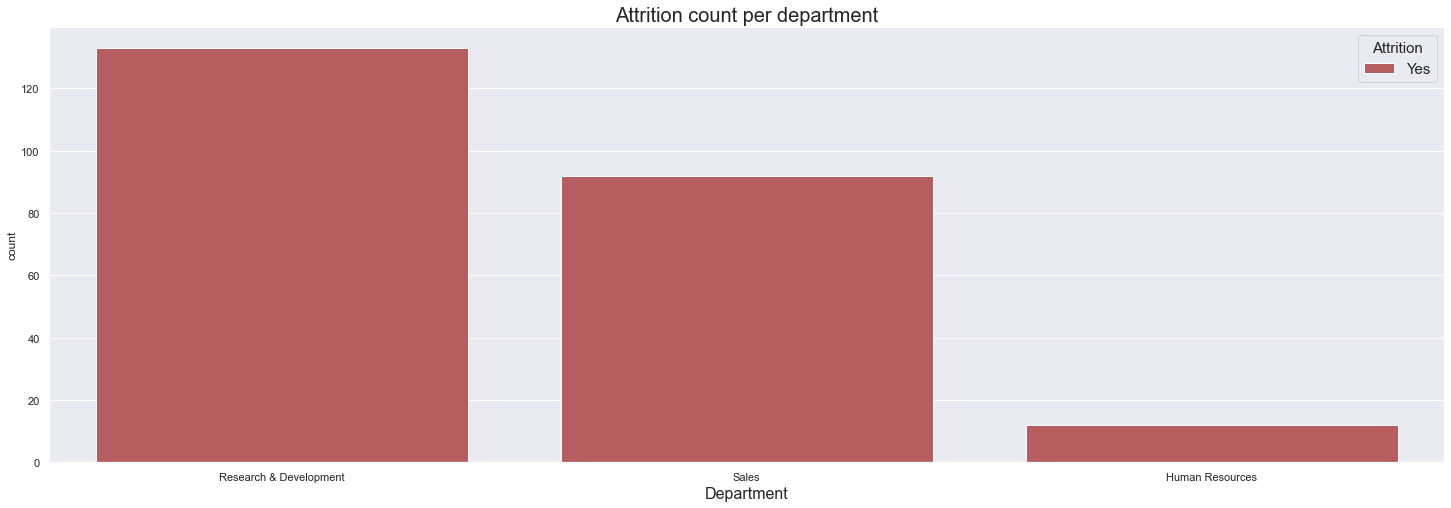

In [54]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='department', hue='attrition', data=df_left, palette=['r'],
             order=df_left['department'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per department", fontsize=20)

# sets xlabel
plt.xlabel('Department', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, **Research & Development has more turnovers** than other departments.

### H25. Which education field has more turnover?

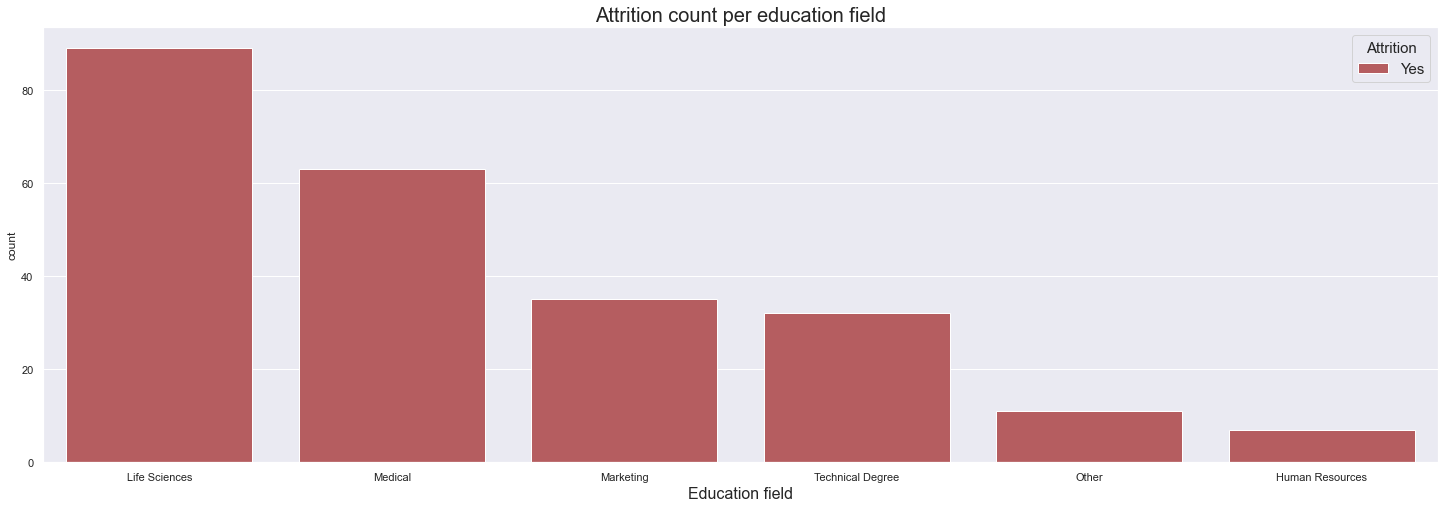

In [55]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='education_field', hue='attrition', data=df_left, palette=['r'],
             order=df_left['education_field'].value_counts().index)

# sets plot title
ax.set_title("Attrition count per education field", fontsize=20)

# sets xlabel
plt.xlabel('Education field', fontsize=16)

# sets the legend
plt.legend(title="Attrition", labels=['Yes'], title_fontsize=15, fontsize=15)

# display plots
plt.show()

As observed, **Life Sciences** is the education field which has more turnover, followed by Medical and Marketing.

## 4.3 Multivariate analysis

### 4.3.1 Numerical attributes

In [56]:
num_attributes.head()

,age,daily_rate,distance_from_home,education,employee_count,employee_number,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,1102,1,2,1,1,2,94,3,2,4,5993,19479,8,11,3,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,2,5130,24907,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,3,2090,2396,6,15,3,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,3,2909,23159,1,11,3,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,2,3468,16632,9,12,3,4,80,1,6,3,3,2,2,2,2


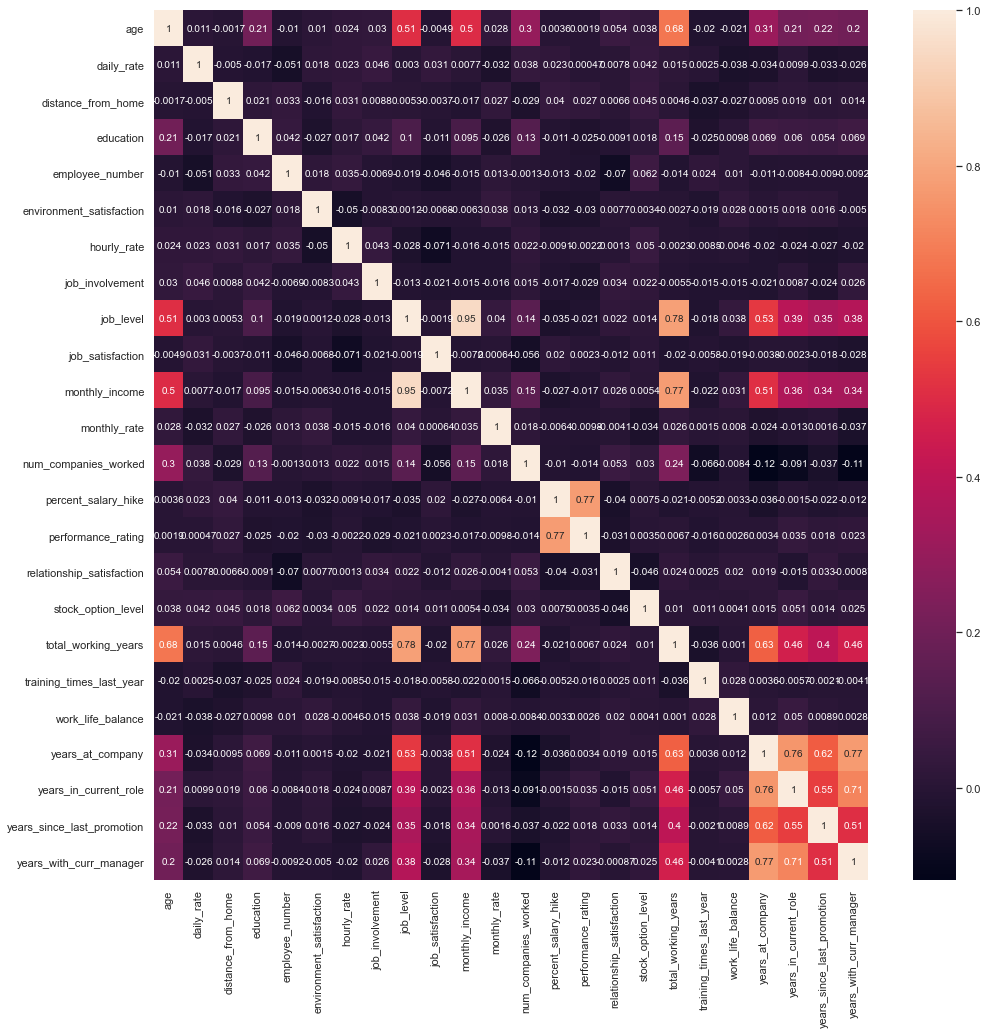

In [57]:
# gets the correlation between the numerical variables
correlation = num_attributes.drop(['employee_count','standard_hours'], axis=1).corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

### 4.3.2 Categorical attributes

In [58]:
cat_attributes.head()

,attrition,business_travel,department,education_field,gender,job_role,marital_status,over18,over_time
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


In [59]:
# builds contingency matrix
contigency_matrix = pd.crosstab(cat_attributes['job_role'], cat_attributes['department']).values

# getting the chi-squared
chi2 = chi2_contingency(contigency_matrix)[0]

# getting the sum of all values in the matrix
n = contigency_matrix.sum()

# getting the rows, cols
r, k = contigency_matrix.shape

# calculates Cramér V
cramer_v_val = np.sqrt((chi2/n) / min(k-1, r-1))

# makes all the possible combinations between categorical variables
a1 = cramer_v(cat_attributes['job_role'], cat_attributes['job_role'])
a2 = cramer_v(cat_attributes['job_role'], cat_attributes['department'])
a3 = cramer_v(cat_attributes['job_role'], cat_attributes['business_travel'])

a4 = cramer_v(cat_attributes['department'], cat_attributes['job_role'])
a5 = cramer_v(cat_attributes['department'], cat_attributes['department'])
a6 = cramer_v(cat_attributes['department'], cat_attributes['business_travel'])

a7 = cramer_v(cat_attributes['over_time'], cat_attributes['job_role'])
a8 = cramer_v(cat_attributes['over_time'], cat_attributes['department'])
a9 = cramer_v(cat_attributes['over_time'], cat_attributes['business_travel'])

# builds the dataset to make the correlations
d = pd.DataFrame({'job_role': [a1, a2, a3],
                  'department': [a4, a5, a6],
                  'business_travel': [a7, a8, a9]
                 })

# sets index equal to columns
d = d.set_index(d.columns)
d

,job_role,department,business_travel
job_role,1.002732,0.940031,0.066840
department,0.940031,1.000681,0.007924
business_travel,0.063869,0.008236,0.044065


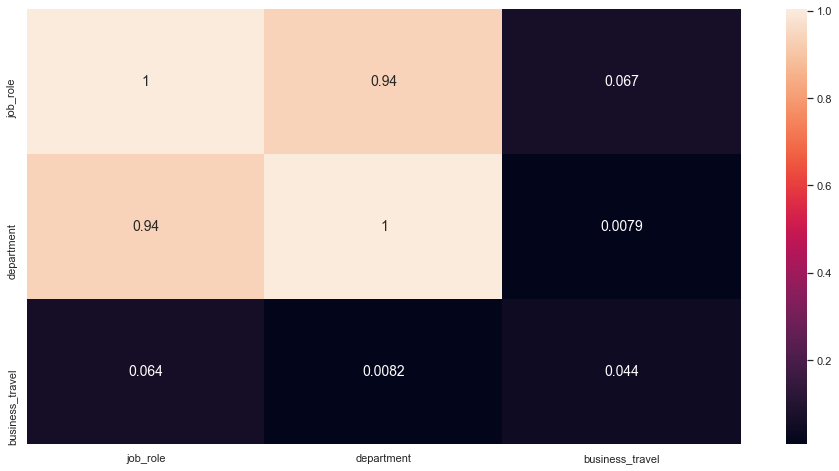

In [60]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# displays plot
plt.show()

# 5.0 Data preparation

### 5.0.1 Project checkpoint

In [61]:
# saves progress
df3 = df2.copy()

## 5.1 Normalization

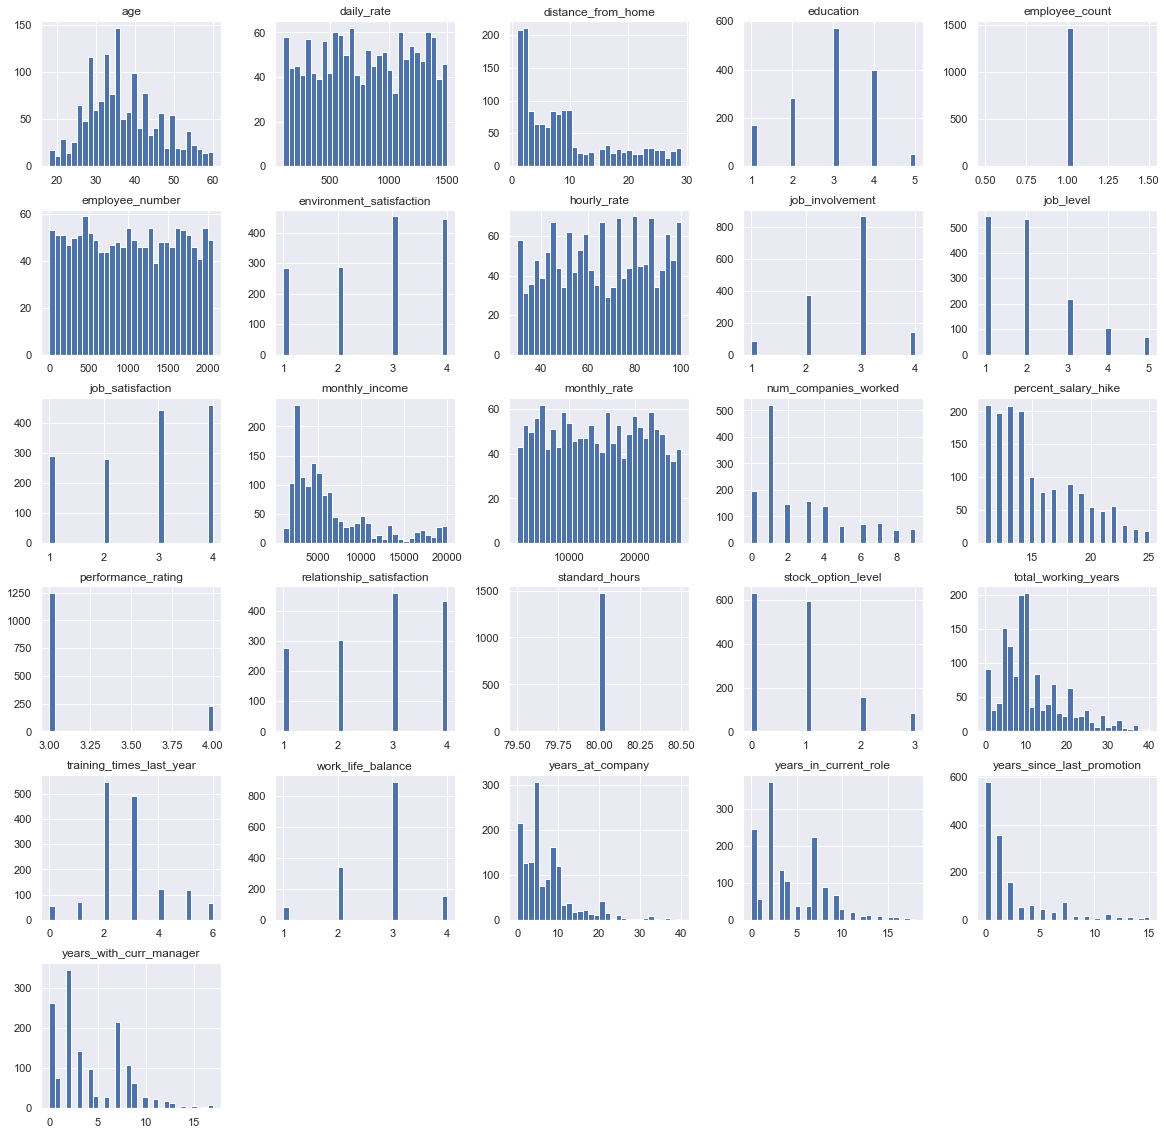

In [62]:
# plots a histogram for all numerical attributes
_ = num_attributes.hist(bins=30, figsize=(20,20))

As we can observe, despite the `age` variable, there is no other variable presenting a normal distribution, not even nearly normal. Even though, `age` doesn't present a completely normal distribution. So, it is preferred to leave as it is than to risk a erroneous normalization.

## 5.2 Rescaling

In [63]:
# selects only numerical data types variables
df_numerical_vars = df3.select_dtypes(include=['int64']).drop('attrition', axis=1)

In [64]:
# instantiates the classes
mms = MinMaxScaler()

In [65]:
# we need to scale the data because the range of variables vary a lot within them
# treat the features equally
scaled_numerical = mms.fit_transform(df_numerical_vars)

# saves the rescaling
pickle.dump(mms, open('parameter/numerical_vars_scaler.pkl', 'wb'))

In [66]:
# gets the Data Frame version of numerical scaled for later manipulation
df_scaled_numerical = pd.DataFrame(scaled_numerical)

# renaming the columns of result Data Frame
df_scaled_numerical.columns = df_numerical_vars.columns

## 5.3 Transformation

### 5.3.1 Encoding

#### 5.3.1.1 One hot encoding for [`department`, `education_field`, `job_role`, `marital_status`]

In [67]:
# instantiates the encoder
ohe = OneHotEncoder()

In [68]:
# selects only categorical data types variables
df_categorical_vars = df3.select_dtypes(include=['object'])

In [69]:
# One Hot Encoding
encoded_categorical = ohe.fit_transform(df_categorical_vars.drop('business_travel', axis=1)).toarray()

# saves the encoder
pickle.dump(ohe, open('parameter/categorical_vars_scaler.pkl', 'wb'))

In [70]:
# convert do DataFrame
df_encoded_categorical = pd.DataFrame(encoded_categorical)

#### 5.3.1.2 Ordinal encoding for `business_travel`

In [71]:
# Ordinal Encoding - as there is an order
# explicitly dictates the encoding codes
assortment_dict = {'Non-Travel': 1,
                  'Travel_Rarely': 2,
                  'Travel_Frequently': 3
                  }

# extracts the column
business_travel = df_categorical_vars['business_travel']

# maps the values from the dict and converts to DataFrame for later manipulation
df_business_travel = pd.DataFrame(business_travel.map(assortment_dict))

#### 5.3.1.3 Joining encoded categorical vars

In [72]:
# joins the encoded vars into one DataFrame
df_encoded_all_categorical = pd.concat([df_business_travel, df_encoded_categorical], axis=1)
df_encoded_all_categorical

,business_travel,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 5.4 Joining everything

In [73]:
# joins scaled and encoded explain vars
df_explain_vars = pd.concat([df_scaled_numerical, df_encoded_all_categorical], axis=1)

# joins target and all explain vars
df4 = pd.concat([df3[['attrition']], df_explain_vars], axis=1)
df4

,attrition,age,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,business_travel,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1,0.547619,0.715820,0.000000,0.25,0.333333,0.914286,0.666667,0.25,1.000000,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.000000,0.000000,0.150,0.222222,0.000000,0.294118,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,0.738095,0.126700,0.250000,0.00,0.666667,0.442857,0.333333,0.25,0.333333,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.500000,0.666667,0.250,0.388889,0.066667,0.411765,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,0.452381,0.909807,0.035714,0.25,1.000000,0.885714,0.333333,0.00,0.666667,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.500000,0.666667,0.000,0.000000,0.000000,0.000000,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0.357143,0.923407,0.071429,0.75,1.000000,0.371429,0.666667,0.00,0.666667,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.500000,0.666667,0.200,0.388889,0.200000,0.000000,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0.214286,0.350036,0.035714,0.00,0.000000,0.142857,0.666667,0.00,0.333333,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.500000,0.666667,0.050,0.111111,0.133333,0.117647,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,0.428571,0.559771,0.785714,0.25,0.666667,0.157143,1.000000,0.25,1.000000,0.082254,0.409396,0.444444,0.0,0.428571,0.0,0.666667,0.333333,0.425,0.500000,0.666667,0.125,0.111111,0.000000,0.176471,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,0,0.500000,0.365784,0.178571,0.00,1.000000,0.171429,0.333333,0.50,0.000000,0.472986,0.777474,0.444444,0.0,0.285714,0.0,0.000000,0.333333,0.225,0.833333,0.666667,0.175,0.388889,0.066667,0.411765,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,0,0.214286,0.037938,0.107143,0.50,0.333333,0.814286,1.000000,0.25,0.333333,0.270300,0.123670,0.111111,1.0,0.642857,1.0,0.333333,0.333333,0.150,0.000000,0.666667,0.150,0.111111,0.000000,0.176471,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,0,0.738095,0.659270,0.035714,0.50,1.000000,0.471429,0.333333,0.25,0.333333,0.230700,0.447661,0.222222,0.0,0.214286,0.0,1.000000,0.000000,0.425,0.500000,0.333333,0.225,0.333333,0.000000,0.470588,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 5.5 Exporting data set

In [74]:
df4.to_csv('data/data_set_section_5.csv', index=False)

# 6.0 Feature selection

### 6.0.1 Project checkpoint

In [75]:
# saves data set current state
df6 = df4.copy()

In [76]:
# loads saved data set
df6 = pd.read_csv('data/data_set_section_5.csv', low_memory=False)

# concatenates with employee_number
df6 = pd.concat([df_employee[['employee_number']], df6], axis=1)

df6

,employee_number,attrition,age,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,business_travel,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1,1,0.547619,0.715820,0.000000,0.25,0.333333,0.914286,0.666667,0.25,1.000000,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.000000,0.000000,0.150,0.222222,0.000000,0.294118,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2,0,0.738095,0.126700,0.250000,0.00,0.666667,0.442857,0.333333,0.25,0.333333,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.500000,0.666667,0.250,0.388889,0.066667,0.411765,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,1,0.452381,0.909807,0.035714,0.25,1.000000,0.885714,0.333333,0.00,0.666667,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.500000,0.666667,0.000,0.000000,0.000000,0.000000,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5,0,0.357143,0.923407,0.071429,0.75,1.000000,0.371429,0.666667,0.00,0.666667,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.500000,0.666667,0.200,0.388889,0.200000,0.000000,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,7,0,0.214286,0.350036,0.035714,0.00,0.000000,0.142857,0.666667,0.00,0.333333,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.500000,0.666667,0.050,0.111111,0.133333,0.117647,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,0,0.428571,0.559771,0.785714,0.25,0.666667,0.157143,1.000000,0.25,1.000000,0.082254,0.409396,0.444444,0.0,0.428571,0.0,0.666667,0.333333,0.425,0.500000,0.666667,0.125,0.111111,0.000000,0.176471,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,2062,0,0.500000,0.365784,0.178571,0.00,1.000000,0.171429,0.333333,0.50,0.000000,0.472986,0.777474,0.444444,0.0,0.285714,0.0,0.000000,0.333333,0.225,0.833333,0.666667,0.175,0.388889,0.066667,0.411765,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1467,2064,0,0.214286,0.037938,0.107143,0.50,0.333333,0.814286,1.000000,0.25,0.333333,0.270300,0.123670,0.111111,1.0,0.642857,1.0,0.333333,0.333333,0.150,0.000000,0.666667,0.150,0.111111,0.000000,0.176471,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,2065,0,0.738095,0.659270,0.035714,0.50,1.000000,0.471429,0.333333,0.25,0.333333,0.230700,0.447661,0.222222,0.0,0.214286,0.0,1.000000,0.000000,0.425,0.500000,0.333333,0.225,0.333333,0.000000,0.470588,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 6.1 Split data set into train and test

In [77]:
# creates arrays for the features and target variable
y = df6['attrition'].values
X = df6.drop('attrition', axis=1).values

# splits into training and test set
X_train_e, X_test_e, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# deletes info equivalent to the employee_number
X_train = np.delete(X_train_e, 0, 1)
X_test = np.delete(X_test_e, 0, 1)

In [78]:
pd.DataFrame(X_test_e)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,1834.0,0.238095,0.798139,0.000000,0.50,0.666667,0.528571,0.666667,0.00,0.000000,0.135966,0.426621,0.111111,0.0,1.000000,1.0,0.666667,0.333333,0.075,0.500000,0.666667,0.075,0.111111,0.066667,0.117647,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1671.0,0.333333,0.626342,0.035714,0.50,1.000000,0.214286,0.666667,0.25,0.333333,0.234913,0.940534,0.000000,0.0,0.142857,0.0,0.666667,0.666667,0.250,0.666667,0.333333,0.225,0.277778,0.066667,0.352941,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1446.0,0.333333,0.357194,0.214286,1.00,1.000000,0.957143,0.666667,0.25,1.000000,0.431543,0.853202,0.444444,0.0,0.071429,0.0,0.666667,0.333333,0.175,0.500000,0.333333,0.100,0.166667,0.000000,0.176471,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1701.0,0.380952,0.412312,0.642857,0.50,0.333333,0.071429,0.333333,0.00,1.000000,0.101106,0.732544,0.111111,0.0,0.071429,0.0,0.333333,0.000000,0.250,0.500000,0.666667,0.250,0.500000,0.533333,0.411765,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,760.0,0.500000,0.027917,0.071429,0.50,0.666667,0.200000,1.000000,0.25,0.333333,0.283307,0.669464,1.000000,0.0,0.285714,0.0,0.666667,0.333333,0.300,0.500000,0.000000,0.200,0.166667,0.200000,0.352941,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,806.0,0.285714,0.586256,0.000000,0.50,1.000000,0.114286,0.000000,0.00,0.666667,0.148710,0.894640,0.333333,0.0,0.714286,1.0,0.666667,0.666667,0.175,0.333333,0.666667,0.050,0.111111,0.000000,0.117647,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
364,802.0,0.452381,0.335719,0.321429,0.00,1.000000,0.742857,0.666667,0.00,0.000000,0.093365,0.715158,0.000000,1.0,0.142857,0.0,0.333333,0.666667,0.150,0.500000,0.333333,0.125,0.166667,0.266667,0.176471,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
365,1177.0,0.190476,0.917681,0.071429,0.75,0.000000,0.742857,1.000000,0.00,1.000000,0.179621,0.454808,0.111111,0.0,0.785714,1.0,0.333333,0.333333,0.200,0.333333,0.666667,0.200,0.388889,0.000000,0.411765,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
366,1969.0,0.857143,0.037938,0.285714,0.25,0.000000,0.528571,0.666667,0.25,0.666667,0.099421,0.818310,0.333333,0.0,0.000000,0.0,0.666667,0.666667,0.225,1.000000,0.333333,0.100,0.166667,0.133333,0.176471,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 6.2 Boruta as feature selector

In [79]:
# define training test data for Boruta
X_train_n = df6.drop('attrition', axis=1).values
y_train_n = df6['attrition'].values.ravel()

In [80]:
# define RandomForestClassifier
# uses all cores from CPU
rf_clf = RandomForestClassifier(n_jobs=-1)

In [81]:
# define Boruta
# boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from Boruta

In [82]:
# gets the ranked list of features
# cols_selected = boruta.support_.tolist()
# df6.drop('attrition', axis=1).iloc[:, cols_selected].columns.to_list()

# 7.0 Machine Learning modeling

### **Tagert variable:** `attrition` (`0` = No. Employee may not leave ; `1` = Yes. Employee may leave)

## 7.1 Logistic Regression model

### 7.1.1 Model fit & Main metrics

In [83]:
# instantiates the classifier
lr_clf = LogisticRegression(max_iter=220, solver='liblinear', random_state=42)

# fits the classifier to training data
lr_clf.fit(X_train, y_train)

# predict the labeld of the test data
y_pred = lr_clf.predict(X_test)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)

# calculates model metrics
lr_accuracy, lr_f1, lr_auc = calculate_model_metrics(lr_clf, X_test, y_test, y_pred, lr_probs)

print('Accuracy: {:.4f} %'.format(100 * lr_accuracy))

print('F1-Score: {:.4f}'.format(lr_f1))

print('PR AUC: {:.4f}'.format(lr_auc))

Accuracy: 87.5000 %
F1-Score: 0.4889
PR AUC: 0.5799


### 7.1.2 PR AUC & Heatmap

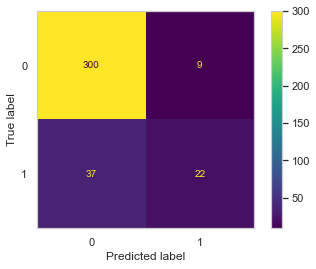

In [84]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(lr_clf, X_test, y_test)

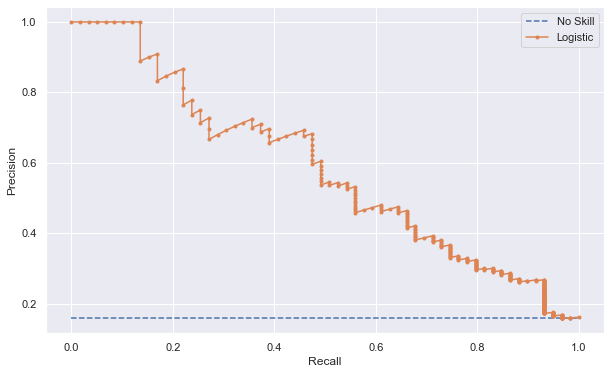

In [85]:
# set seaborn default stype
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, lr_probs, 'Logistic')

# display plots
plt.show()

### 7.1.3 Classification report

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       309
           1       0.71      0.37      0.49        59

    accuracy                           0.88       368
   macro avg       0.80      0.67      0.71       368
weighted avg       0.86      0.88      0.86       368



## 7.2 Random Forest classifier

### 7.2.1 Model fit & Main metrics

In [87]:
# instantiates the classifier
rf_clf = RandomForestClassifier(random_state=42)

# fits the classifier to training data
rf_clf.fit(X_train, y_train)

# predict the labeld of the test data
y_pred = rf_clf.predict(X_test)

# predict probabilities
rf_probs = rf_clf.predict_proba(X_test)

# calculates model metrics
rf_accuracy, rf_f1, rf_auc = calculate_model_metrics(rf_clf, X_test, y_test, y_pred, rf_probs)

print('Accuracy: {:.4f} %'.format(100 * rf_accuracy))

print('F1-Score: {:.4f}'.format(rf_f1))

print('PR AUC: {:.4f}'.format(rf_auc))

Accuracy: 84.2391 %
F1-Score: 0.1944
PR AUC: 0.4167


### 7.2.1 PR AUC & Heatmap

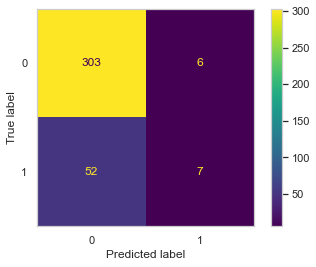

In [88]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(rf_clf, X_test, y_test)

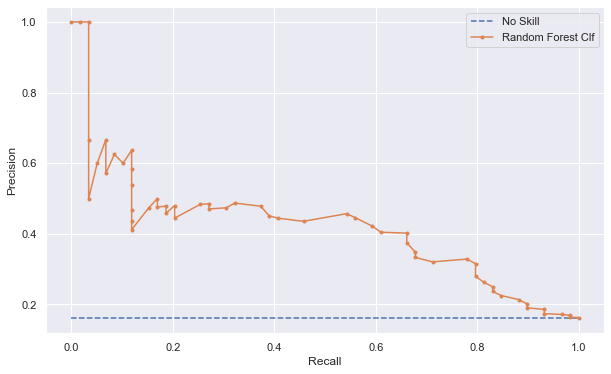

In [89]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, rf_probs, 'Random Forest Clf')

# display plots
plt.show()

### 7.2.2 Classification report

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       309
           1       0.54      0.12      0.19        59

    accuracy                           0.84       368
   macro avg       0.70      0.55      0.55       368
weighted avg       0.80      0.84      0.80       368



## 7.3 XGBoost classifier

### 7.3.1 Model fit & Main metrics

In [91]:
# instantiates the classifier
xgb_clf = XGBClassifier(colsample_bytree=0.5, subsample=0.75, random_state=42)

# fits the classifier to training data
xgb_clf.fit(X_train, y_train)

# predict the labeld of the test data
y_pred = xgb_clf.predict(X_test)

# predict probabilities
xgb_probs = xgb_clf.predict_proba(X_test)

# calculates model metrics
xgb_accuracy, xgb_f1, xgb_auc = calculate_model_metrics(xgb_clf, X_test, y_test, y_pred, xgb_probs)

print('Accuracy: {:.4f} %'.format(100 * xgb_accuracy))

print('F1-Score: {:.4f}'.format(xgb_f1))

print('PR AUC: {:.4f}'.format(xgb_auc))

Accuracy: 86.6848 %
F1-Score: 0.4096
PR AUC: 0.4938


### 7.3.2 PR AUC & Heatmap

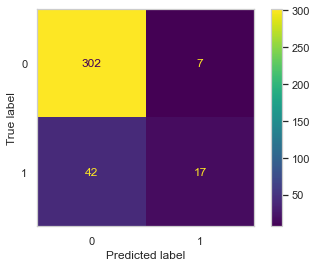

In [92]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(xgb_clf, X_test, y_test)

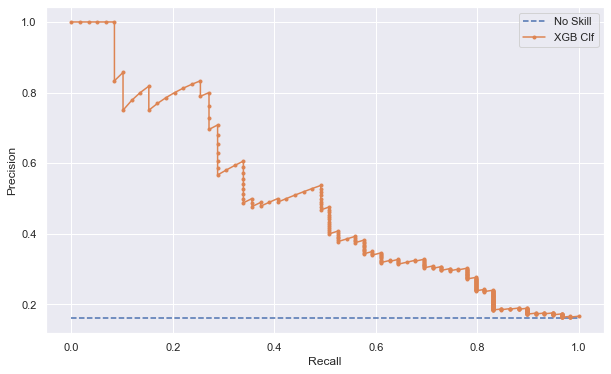

In [93]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, xgb_probs, 'XGB Clf')

# display plots
plt.show()

### 7.3.3 Classification report

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92       309
           1       0.71      0.29      0.41        59

    accuracy                           0.87       368
   macro avg       0.79      0.63      0.67       368
weighted avg       0.85      0.87      0.84       368



## 7.4 XGBoost Random Forest classifier

### 7.4.1 Model fit & Main metrics

In [95]:
# instantiates the classifier
xgbrf_clf = XGBRFClassifier(random_state=42)

# fits the classifier to training data
xgbrf_clf.fit(X_train, y_train)

# predict the label of the test data
y_pred = xgbrf_clf.predict(X_test)

# predict probabilities
xgbrf_probs = xgbrf_clf.predict_proba(X_test)

# calculates model metrics
xgbrf_accuracy, xgbrf_f1, xgbrf_auc = calculate_model_metrics(xgbrf_clf, X_test, y_test, y_pred, xgbrf_probs)

print('Accuracy: {:.4f} %'.format(100 * xgbrf_accuracy))

print('F1-Score: {:.4f}'.format(xgbrf_f1))

print('PR AUC: {:.4f}'.format(xgbrf_auc))

Accuracy: 84.2391 %
F1-Score: 0.2927
PR AUC: 0.4208


### 7.4.2 PR AUC & Heatmap

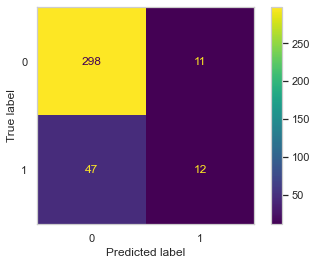

In [96]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(xgbrf_clf, X_test, y_test)

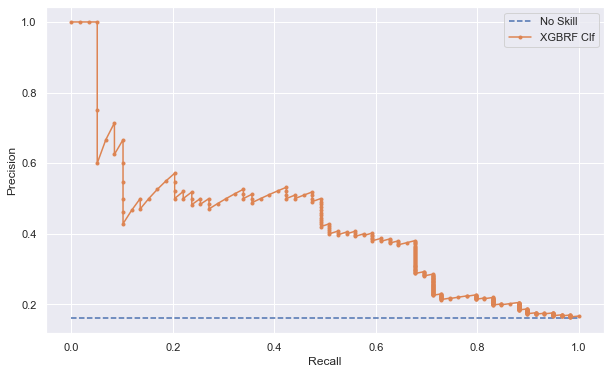

In [97]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, xgbrf_probs, 'XGBRF Clf')

# display plots
plt.show()

### 7.4.3 Classification report

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       309
           1       0.52      0.20      0.29        59

    accuracy                           0.84       368
   macro avg       0.69      0.58      0.60       368
weighted avg       0.81      0.84      0.81       368



## 7.5 Balanced Random Forest classifier

### 7.5.1 Model fit & Main metrics

In [99]:
# instantiates the classifier
brf = BalancedRandomForestClassifier(criterion='entropy', random_state=42)

# fits the classifier to training data
brf.fit(X_train, y_train) 

# predict the label of the test data
y_pred = brf.predict(X_test)

# predict probabilities
brf_probs = brf.predict_proba(X_test)

# calculates model metrics
brf_accuracy, brf_f1, brf_auc = calculate_model_metrics(brf, X_test, y_test, y_pred, brf_probs)

print('Accuracy: {:.4f} %'.format(100 * brf_accuracy))

print('F1-Score: {:.4f}'.format(brf_f1))

print('PR AUC: {:.4f}'.format(brf_auc))

print('Balanced accuracy: {:.4f}'.format(balanced_accuracy_score(y_test, y_pred)*100))

Accuracy: 77.9891 %
F1-Score: 0.5091
PR AUC: 0.4051
Balanced accuracy: 75.2372


### 7.5.2 PR AUC & Heatmap

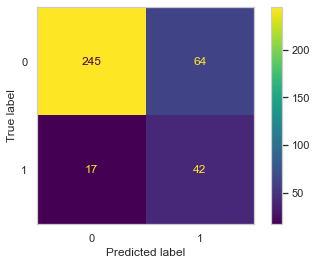

In [100]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(brf, X_test, y_test)

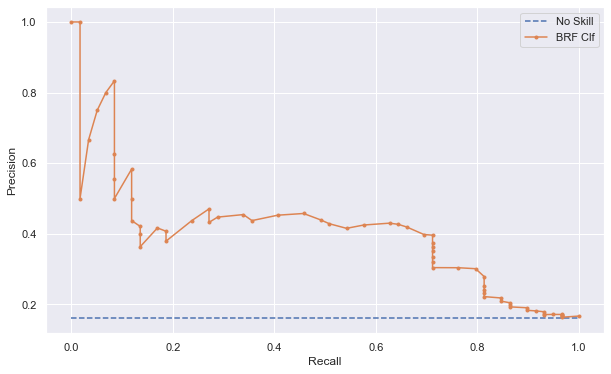

In [101]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, brf_probs, 'BRF Clf')

# display plots
plt.show()

### 7.5.3 Classification report

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       309
           1       0.40      0.71      0.51        59

    accuracy                           0.78       368
   macro avg       0.67      0.75      0.68       368
weighted avg       0.85      0.78      0.80       368



## 7.6 Models - Performance summary

### 7.6.1 Accuracy, F1-Score and PR AUC

In [103]:
# list os classifiers
classifiers = [LogisticRegression(max_iter=220, solver='liblinear', random_state=42),
               RandomForestClassifier(random_state=42),
               XGBClassifier(colsample_bytree=0.5, subsample=0.75, random_state=42),
               XGBRFClassifier(random_state=42),
               BalancedRandomForestClassifier(criterion='entropy', random_state=42)]

# creates empty data frame
df_performance = pd.DataFrame()

# trains each classifier
for clf in classifiers:
    # fits the classifier to training data
    clf.fit(X_train, y_train) 

    # predict the label of the test data
    y_pred = clf.predict(X_test)
    
    # predict probabilities
    clf_probs = clf.predict_proba(X_test)
    
    # calculates model metrics
    clf_accuracy, clf_f1, clf_auc = calculate_model_metrics(clf, X_test, y_test, y_pred, clf_probs)
    
    # creates a dict
    clf_dict = {'model': [type(clf).__name__, '---'],
           'accuracy': [clf_accuracy, np.nan],
           'F1-Score': [clf_f1, np.nan],
           'PR AUC': [clf_auc, np.nan]}
    
    # concatenate Data Frames
    df_performance = pd.concat([df_performance, pd.DataFrame(clf_dict)])


# resets Data Frame index
df_performance = df_performance.reset_index()

# drops index
df_performance.drop('index', axis=1, inplace=True)

# drops unwanted rows that have no data
df_performance.drop([1, 3, 5, 7, 9], inplace=True)

# displays final Data Frame
df_performance

,model,accuracy,F1-Score,PR AUC
0,LogisticRegression,0.875000,0.488889,0.579919
2,RandomForestClassifier,0.842391,0.194444,0.416667
4,XGBClassifier,0.866848,0.409639,0.493807
6,XGBRFClassifier,0.842391,0.292683,0.420753
8,BalancedRandomForestClassifier,0.779891,0.509091,0.405141


### 7.6.2 PR AUC & Heatmap

In [104]:
# list os classifiers
classifiers = [LogisticRegression(max_iter=220, solver='liblinear', random_state=42),
               RandomForestClassifier(random_state=42),
               XGBClassifier(colsample_bytree=0.5, subsample=0.75, random_state=42),
               XGBRFClassifier(random_state=42),
               BalancedRandomForestClassifier(criterion='entropy', random_state=42)]

# trains each classifier
for clf in classifiers:
    clf.fit(X_train, y_train)

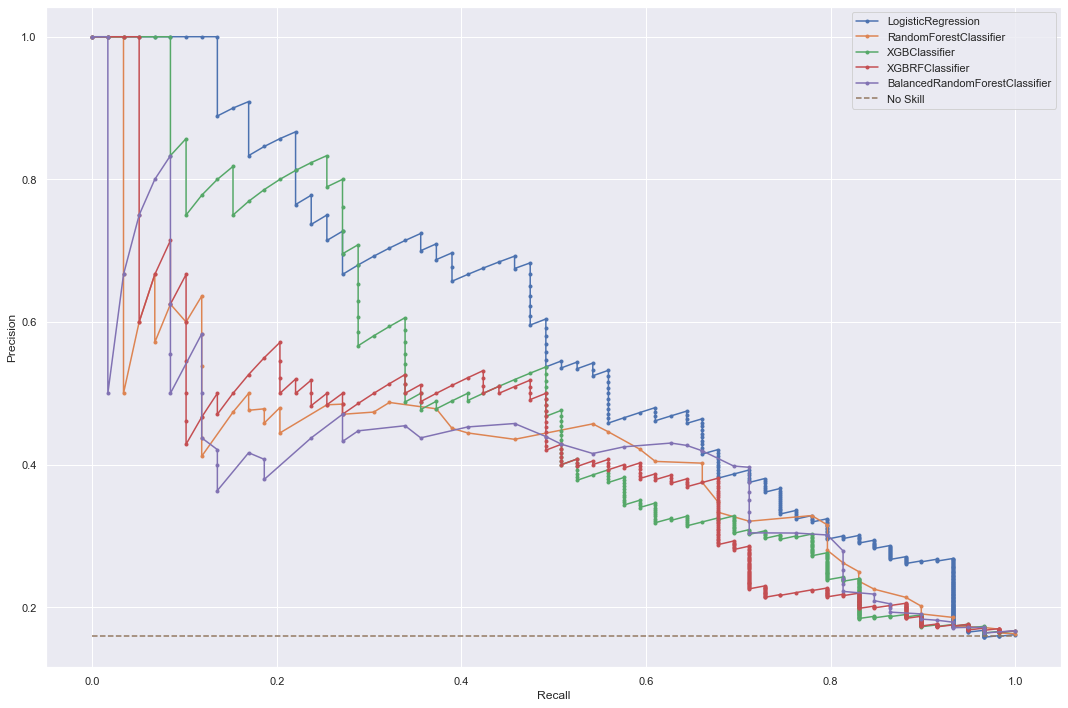

In [105]:
# sets seaborn default style
sns.set()

# define subplots
fig, ax = plt.subplots(figsize=(15,10))

for clf in classifiers:
    # predict probabilities
    clf_probs = clf.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    model_probs = clf_probs[:, 1]

    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    
    # plots the curve
    plt.plot(recall, precision, marker='.', label=type(clf).__name__)
    

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')


# calculates the no-skill baseline
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# adjusts subplot
plt.tight_layout()

# show the legend
plt.legend()

# displays the plot
plt.show()

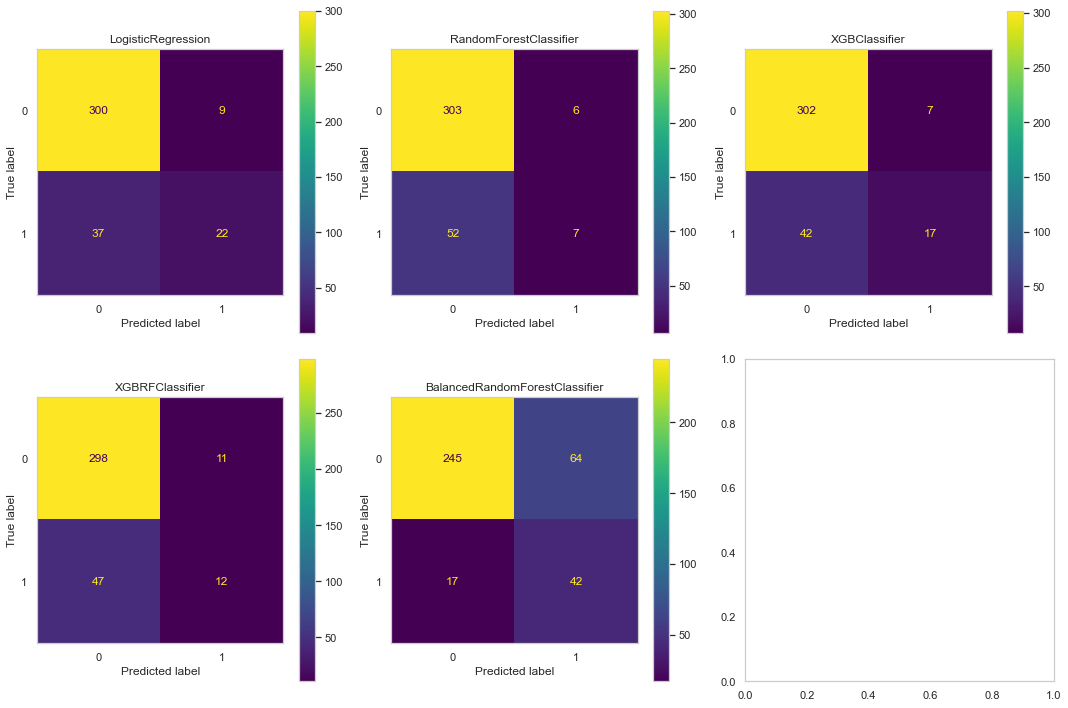

In [106]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

# define subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for clf, ax in zip(classifiers, ax.flatten()):
    plot_confusion_matrix(clf, X_test, y_test, ax=ax)
    ax.title.set_text(type(clf).__name__)


# adjusts subplot
plt.tight_layout()

# displays the plot
plt.show()

# 8.0 Hyperparameter tuning with Cross Validation

## 8.1 Logistic Regression model

### 8.1.1 Cross validation

In [107]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
lr_clf = LogisticRegression(max_iter=220, solver='liblinear', random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
lr_clf_cv = RandomizedSearchCV(lr_clf, param_grid, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
lr_clf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(max_iter=220, random_state=42,
                                                solver='liblinear'),
                   n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])},
                   random_state=42, verbose=2)

### 8.1.2 Model fit & Main metrics

In [108]:
# extract the best estimator
best_model = lr_clf_cv.best_estimator_

# predict the labeld of the test data
y_pred = best_model.predict(X_test)

# predict probabilities
lr_probs = best_model.predict_proba(X_test)

# calculates model metrics
lr_accuracy, lr_f1, lr_auc = calculate_model_metrics(best_model, X_test, y_test, y_pred, lr_probs)

print('Accuracy: {:.4f} %'.format(100 * lr_accuracy))

print('F1-Score: {:.4f}'.format(lr_f1))

print('PR AUC: {:.4f}'.format(lr_auc))

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(lr_clf_cv.best_params_)) 
print("Best score is {}".format(lr_clf_cv.best_score_))

Accuracy: 86.9565 %
F1-Score: 0.4286
PR AUC: 0.5750
Tuned Parameters: {'C': 0.4393970560760795}
Best score is 0.8847583947583948


### 8.1.3 PR AUC & Heatmap

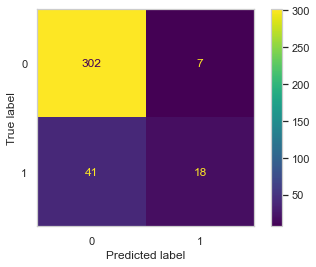

In [109]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(best_model, X_test, y_test)

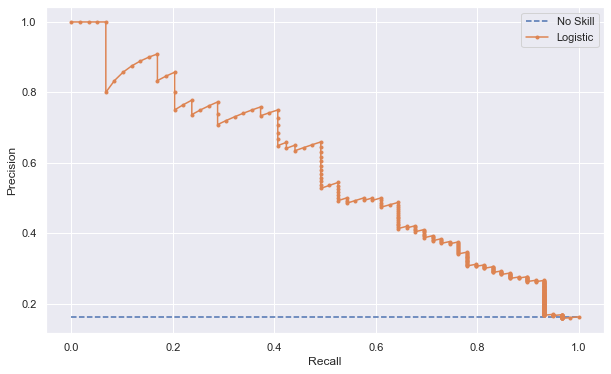

In [110]:
# set seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, lr_probs, 'Logistic')

# display plots
plt.show()

### 8.1.4 Classification report

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       309
           1       0.72      0.31      0.43        59

    accuracy                           0.87       368
   macro avg       0.80      0.64      0.68       368
weighted avg       0.85      0.87      0.85       368



## 8.2 Random Forest classifier

### 8.2.1 Cross validation

In [112]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': [3, None],
              'max_features': randint(1, 9),
              'min_samples_leaf': randint(1, 9),
              'criterion': ['gini', 'entropy']}

# Instantiate a logistic regression classifier: logreg
rf_clf = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
rf_clf_cv = RandomizedSearchCV(rf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
rf_clf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd653d8f890>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd653d8f4d0>},
                   random_state=42, verbose=2)

### 8.2.2 Model fit & Main metrics

In [113]:
# extract the best estimator
best_model = rf_clf_cv.best_estimator_

# predict the labeld of the test data
y_pred = best_model.predict(X_test)

# predict probabilities
rf_probs = best_model.predict_proba(X_test)

# calculates model metrics
rf_accuracy, rf_f1, rf_auc = calculate_model_metrics(best_model, X_test, y_test, y_pred, rf_probs)

print('Accuracy: {:.4f} %'.format(100 * rf_accuracy))

print('F1-Score: {:.4f}'.format(rf_f1))

print('PR AUC: {:.4f}'.format(rf_auc))

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(rf_clf_cv.best_params_)) 
print("Best score is {}".format(rf_clf_cv.best_score_))

Accuracy: 83.9674 %
F1-Score: 0.1690
PR AUC: 0.4096
Tuned Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 2}
Best score is 0.8656592956592956


### 8.2.3 PR AUC & Heatmap

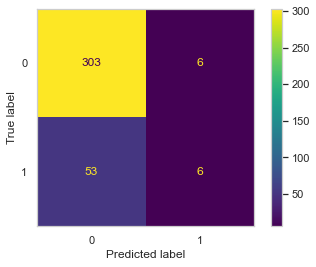

In [114]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(best_model, X_test, y_test)

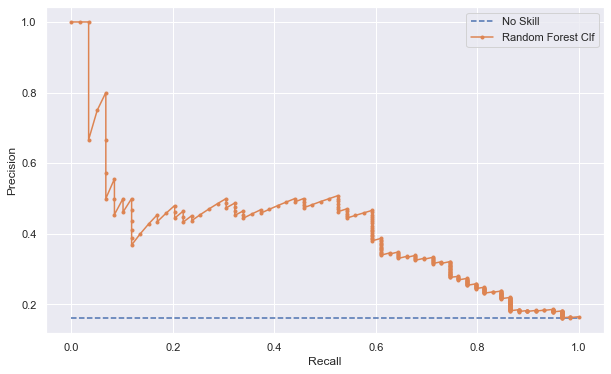

In [115]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, rf_probs, 'Random Forest Clf')

# display plots
plt.show()

### 8.2.4 Classification report

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       309
           1       0.50      0.10      0.17        59

    accuracy                           0.84       368
   macro avg       0.68      0.54      0.54       368
weighted avg       0.79      0.84      0.79       368



## 8.3 XGBoost classifier

### 8.3.1 Cross validation

In [117]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': list(range(3, 12)),
              'gamma': [0, 0.001, 0.01, 0.1],
              'subsample': [0.25, 0.5, 0.75, 1],
              'learning_rate': np.linspace(0.01, 0.5, 10),
              'n_estimators': [10, 25, 40, 75, 100]
             }

# Instantiate a logistic regression classifier: logreg
xgb_clf = XGBClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
xgb_clf_cv = RandomizedSearchCV(xgb_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
xgb_clf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

### 8.3.2 Model fit & Main metrics

In [118]:
# extract the best estimator
best_model = xgb_clf_cv.best_estimator_

# predict the labeld of the test data
y_pred = best_model.predict(X_test)

# predict probabilities
xgb_probs = best_model.predict_proba(X_test)

# calculates model metrics
xgb_accuracy, xgb_f1, xgb_auc = calculate_model_metrics(best_model, X_test, y_test, y_pred, xgb_probs)

print('Accuracy: {:.4f} %'.format(100 * xgb_accuracy))

print('F1-Score: {:.4f}'.format(xgb_f1))

print('PR AUC: {:.4f}'.format(xgb_auc))

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(xgb_clf_cv.best_params_)) 
print("Best score is {}".format(xgb_clf_cv.best_score_))

Accuracy: 83.9674 %
F1-Score: 0.2716
PR AUC: 0.4155
Tuned Parameters: {'subsample': 0.75, 'n_estimators': 40, 'max_depth': 11, 'learning_rate': 0.5, 'gamma': 0.01}
Best score is 0.8738902538902538


### 8.3.3 PR AUC & Heatmap

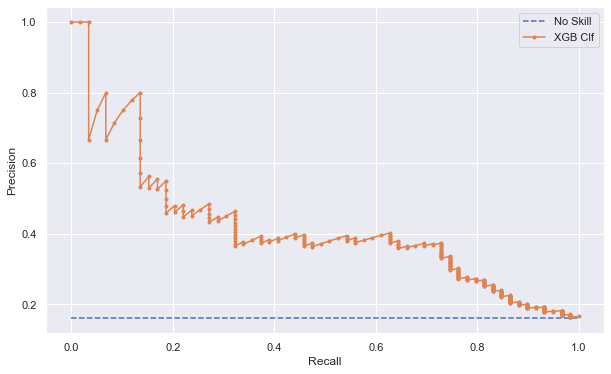

In [119]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, xgb_probs, 'XGB Clf')

# display plots
plt.show()

### 8.3.4 Classification report

In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       309
           1       0.50      0.19      0.27        59

    accuracy                           0.84       368
   macro avg       0.68      0.58      0.59       368
weighted avg       0.80      0.84      0.81       368



## 8.4 XGBoost Random Forest classifier

### 8.4.1 Cross validation

In [121]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': list(range(3, 12)),
              'gamma': [0, 0.001, 0.01, 0.1],
              'colsample_bytree': [0.25, 0.5, 0.75, 1],
              'n_estimators': [10, 25, 40, 75, 100]
             }

# Instantiate a logistic regression classifier: logreg
xgbrf_clf = XGBRFClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
xgbrf_clf_cv = RandomizedSearchCV(xgbrf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
xgbrf_clf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomizedSearchCV(cv=10,
                   estimator=XGBRFClassifier(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bytree=None, gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             max_delta_step=None,
                                             max_depth=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
                                             objective='binary:logistic',
                                             ran

### 8.4.2 Model fit & Main metrics

In [122]:
# extract the best estimator
best_model = xgbrf_clf_cv.best_estimator_

# predict the labeld of the test data
y_pred = best_model.predict(X_test)

# predict probabilities
xgbrf_probs = best_model.predict_proba(X_test)

# calculates model metrics
xgbrf_accuracy, xgbrf_f1, xgbrf_auc = calculate_model_metrics(best_model, X_test, y_test, y_pred, xgbrf_probs)

print('Accuracy: {:.4f} %'.format(100 * xgbrf_accuracy))

print('F1-Score: {:.4f}'.format(xgbrf_f1))

print('PR AUC: {:.4f}'.format(xgbrf_auc))

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(xgbrf_clf_cv.best_params_)) 
print("Best score is {}".format(xgbrf_clf_cv.best_score_))

Accuracy: 83.1522 %
F1-Score: 0.1389
PR AUC: 0.4231
Tuned Parameters: {'n_estimators': 40, 'max_depth': 7, 'gamma': 0.01, 'colsample_bytree': 0.5}
Best score is 0.8620393120393122


### 8.4.3 PR AUC & Heatmap

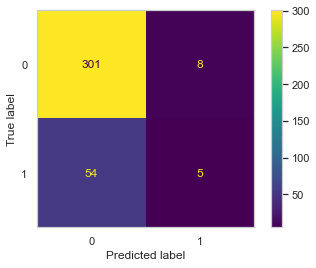

In [123]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(best_model, X_test, y_test)

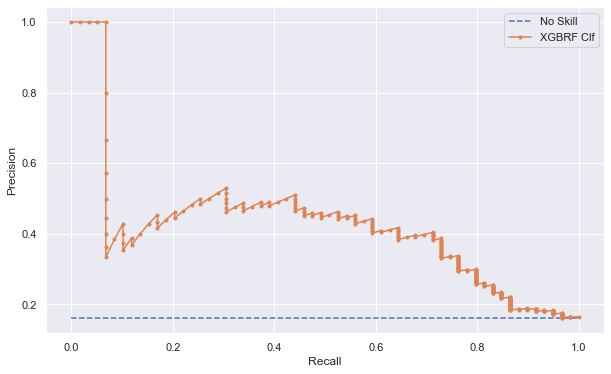

In [124]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, xgbrf_probs, 'XGBRF Clf')

# display plots
plt.show()

### 8.4.4 Classification report

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       309
           1       0.38      0.08      0.14        59

    accuracy                           0.83       368
   macro avg       0.62      0.53      0.52       368
weighted avg       0.77      0.83      0.78       368



## 8.5 Balanced Random Forest classifier

### 8.5.1 Cross validation

In [126]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': [3, 6, 8, 10, None],
              'max_features': randint(1, 9),
              'min_samples_leaf': randint(1, 9),
              'max_features': ['log2', 'auto', 'sqrt'],
              'criterion': ['gini', 'entropy']}

# Instantiate a logistic regression classifier: logreg
brf_clf = BalancedRandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
brf_clf_cv = RandomizedSearchCV(brf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
brf_clf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished


RandomizedSearchCV(cv=10,
                   estimator=BalancedRandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 6, 8, 10, None],
                                        'max_features': ['log2', 'auto',
                                                         'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd656b93050>},
                   random_state=42, verbose=2)

### 8.5.2 Model fit & Main metrics

In [127]:
# extract the best estimator
best_model = brf_clf_cv.best_estimator_

# predict the labeld of the test data
y_pred = best_model.predict(X_test)

# predict probabilities
brf_probs = best_model.predict_proba(X_test)

# calculates model metrics
brf_accuracy, brf_f1, brf_auc = calculate_model_metrics(best_model, X_test, y_test, y_pred, brf_probs)

print('Accuracy: {:.4f} %'.format(100 * brf_accuracy))

print('F1-Score: {:.4f}'.format(brf_f1))

print('PR AUC: {:.4f}'.format(brf_auc))

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(brf_clf_cv.best_params_)) 
print("Best score is {}".format(brf_clf_cv.best_score_))

Accuracy: 77.1739 %
F1-Score: 0.4750
PR AUC: 0.3837
Tuned Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 5}
Best score is 0.7804995904995906


### 8.5.3 PR AUC & Heatmap

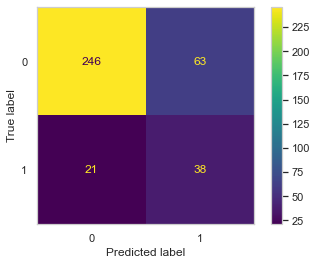

In [128]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(best_model, X_test, y_test)

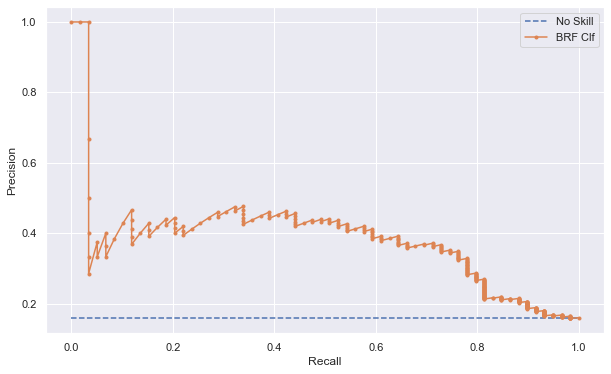

In [129]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, brf_probs, 'BRF Clf')

# display plots
plt.show()

### 8.5.4 Classification report

In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       309
           1       0.38      0.64      0.47        59

    accuracy                           0.77       368
   macro avg       0.65      0.72      0.66       368
weighted avg       0.83      0.77      0.79       368



## 8.5 Models - Performance summary

### 8.5.1 Cross validation

In [131]:
# LOGISTIC REGRESSION

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
lr_clf = LogisticRegression(max_iter=220, solver='liblinear', random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
lr_clf_cv = RandomizedSearchCV(lr_clf, param_grid, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
lr_clf_cv.fit(X_train, y_train)

# --------------------


# RANDOM FOREST CLASSIFIER

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': [3, None],
              'max_features': randint(1, 9),
              'min_samples_leaf': randint(1, 9),
              'criterion': ['gini', 'entropy']}

# Instantiate a logistic regression classifier: logreg
rf_clf = RandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
rf_clf_cv = RandomizedSearchCV(rf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
rf_clf_cv.fit(X_train, y_train)

# --------------------


# XGBOOST CLASSIFIER

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': list(range(3, 12)),
              'gamma': [0, 0.001, 0.01, 0.1],
              'subsample': [0.25, 0.5, 0.75, 1],
              'learning_rate': np.linspace(0.01, 0.5, 10),
              'n_estimators': [10, 25, 40, 75, 100]
             }

# Instantiate a logistic regression classifier: logreg
xgb_clf = XGBClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
xgb_clf_cv = RandomizedSearchCV(xgb_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
xgb_clf_cv.fit(X_train, y_train)

# --------------------


# XGBOOST RANDOM FOREST CLASSIFIER

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': list(range(3, 12)),
              'gamma': [0, 0.001, 0.01, 0.1],
              'colsample_bytree': [0.25, 0.5, 0.75, 1],
              'n_estimators': [10, 25, 40, 75, 100]
             }

# Instantiate a logistic regression classifier: logreg
xgbrf_clf = XGBRFClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
xgbrf_clf_cv = RandomizedSearchCV(xgbrf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
xgbrf_clf_cv.fit(X_train, y_train)

# --------------------


# BALANCED RANDOM FOREST CLASSIFIER

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': [3, 6, 8, 10, None],
              'max_features': randint(1, 9),
              'min_samples_leaf': randint(1, 9),
              'max_features': ['log2', 'auto', 'sqrt'],
              'criterion': ['gini', 'entropy']}

# Instantiate a logistic regression classifier: logreg
brf_clf = BalancedRandomForestClassifier(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
brf_clf_cv = RandomizedSearchCV(brf_clf, param_dist, cv=10, n_iter=10, n_jobs=-1, verbose=2, random_state=42)

# Fit it to the data
brf_clf_cv.fit(X_train, y_train)

# --------------------

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


RandomizedSearchCV(cv=10,
                   estimator=BalancedRandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 6, 8, 10, None],
                                        'max_features': ['log2', 'auto',
                                                         'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6539e6b90>},
                   random_state=42, verbose=2)

### 8.5.1 Accuracy, F1-Score and PR AUC

In [132]:
# list os classifiers
best_classifiers = [lr_clf_cv.best_estimator_,
                    rf_clf_cv.best_estimator_,
                    xgb_clf_cv.best_estimator_,
                    xgbrf_clf_cv.best_estimator_,
                    brf_clf_cv.best_estimator_]

# creates empty data frame
df_performance = pd.DataFrame()

# trains each classifier
for clf in best_classifiers:
    # fits the classifier to training data
    clf.fit(X_train, y_train) 

    # predict the label of the test data
    y_pred = clf.predict(X_test)
    
    # predict probabilities
    clf_probs = clf.predict_proba(X_test)
    
    # calculates model metrics
    clf_accuracy, clf_f1, clf_auc = calculate_model_metrics(clf, X_test, y_test, y_pred, clf_probs)
    
    # creates a dict
    clf_dict = {'model': [type(clf).__name__, '---'],
           'accuracy': [clf_accuracy, np.nan],
           'F1-Score': [clf_f1, np.nan],
           'PR AUC': [clf_auc, np.nan]}
    
    # concatenate Data Frames
    df_performance = pd.concat([df_performance, pd.DataFrame(clf_dict)])


# resets Data Frame index
df_performance = df_performance.reset_index()

# drops index
df_performance.drop('index', axis=1, inplace=True)

# drops unwanted rows that have no data
df_performance.drop([1, 3, 5, 7, 9], inplace=True)

# displays final Data Frame
df_performance

,model,accuracy,F1-Score,PR AUC
0,LogisticRegression,0.869565,0.428571,0.574984
2,RandomForestClassifier,0.839674,0.169014,0.409587
4,XGBClassifier,0.839674,0.271605,0.415530
6,XGBRFClassifier,0.831522,0.138889,0.423128
8,BalancedRandomForestClassifier,0.771739,0.475000,0.383715


### 8.5.2 PR AUC & Heatmap

In [133]:
# list os classifiers
best_classifiers = [lr_clf_cv.best_estimator_,
                    rf_clf_cv.best_estimator_,
                    xgb_clf_cv.best_estimator_,
                    xgbrf_clf_cv.best_estimator_,
                    brf_clf_cv.best_estimator_]

# trains each classifier
for clf in best_classifiers:
    clf.fit(X_train, y_train)

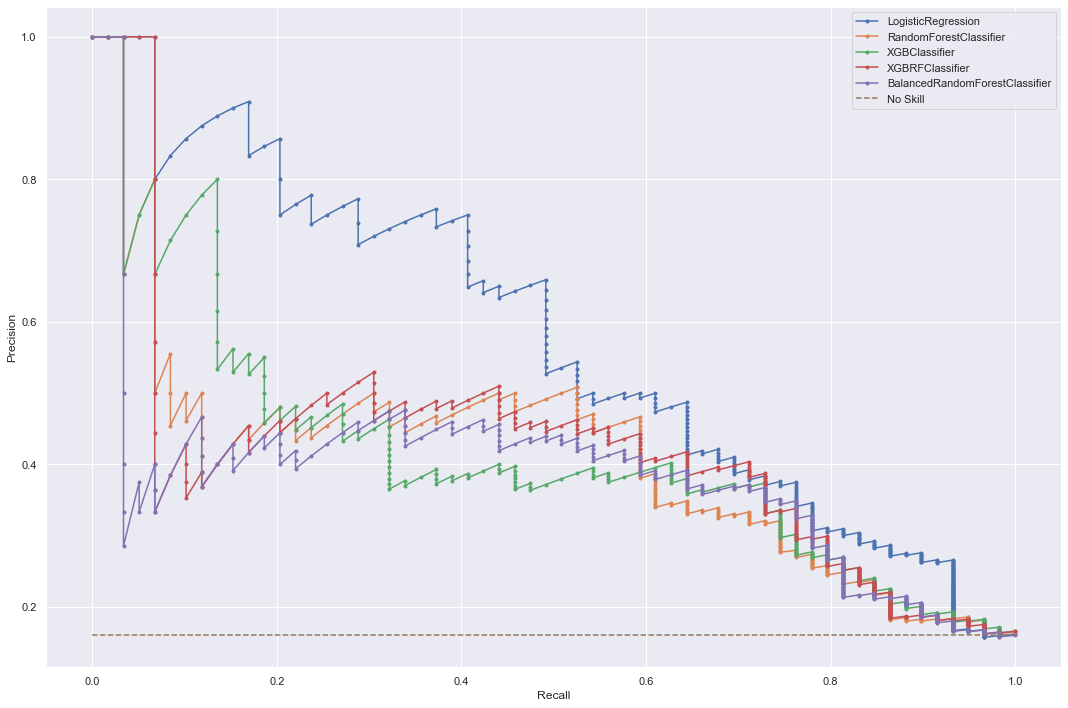

In [134]:
# sets seaborn default style
sns.set()

# define subplots
fig, ax = plt.subplots(figsize=(15,10))

for clf in best_classifiers:
    # predict probabilities
    clf_probs = clf.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    model_probs = clf_probs[:, 1]

    # calculate precision and recall for each threshold
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    
    # plots the curve
    plt.plot(recall, precision, marker='.', label=type(clf).__name__)
    

    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')



# calculates the no-skill baseline
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# adjusts subplot
plt.tight_layout()

# show the legend
plt.legend()

# displays the plot
plt.show()

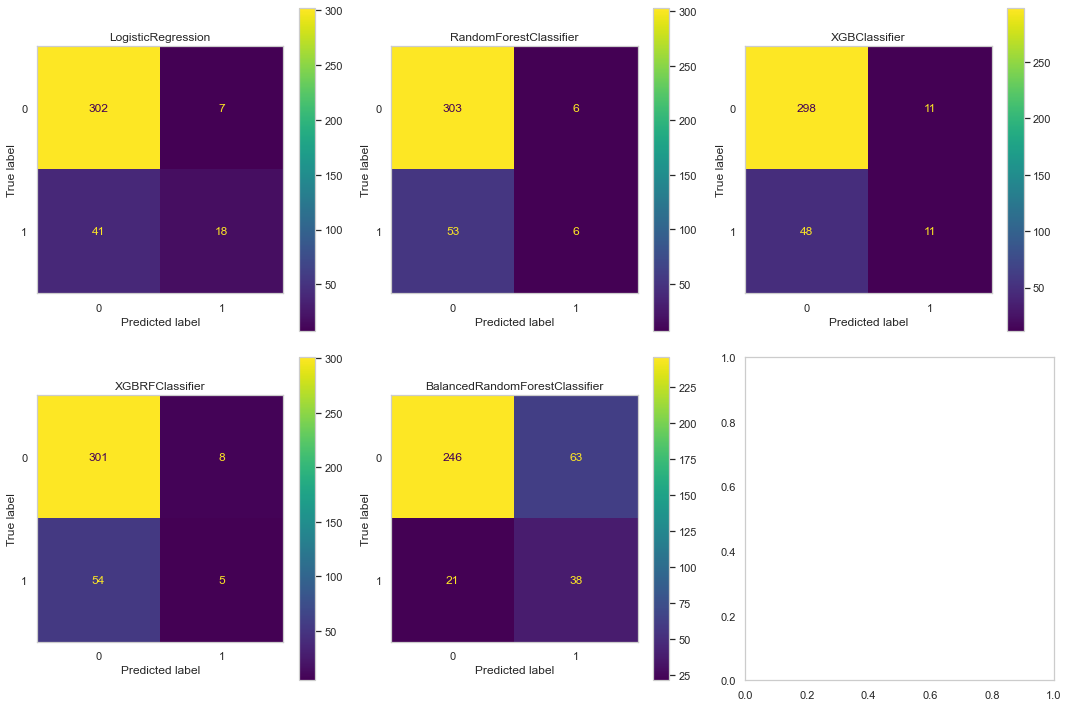

In [135]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

# define subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for clf, ax in zip(best_classifiers, ax.flatten()):
    plot_confusion_matrix(clf, X_test, y_test, ax=ax)
    ax.title.set_text(type(clf).__name__)

    
# adjusts subplots
plt.tight_layout()

# displays the plot
plt.show()

## 8.6 Final Model

### 8.6.1 Model fit & Main metrics

In [136]:
# best params
best_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'replacement': False,
 'sampling_strategy': 'auto',
 'verbose': 0,
 'warm_start': False}

In [137]:
# model
model_brf_clf = BalancedRandomForestClassifier(bootstrap=best_params['bootstrap'],
                                               ccp_alpha=best_params['ccp_alpha'],
                                               class_weight=best_params['class_weight'],
                                               criterion=best_params['criterion'],
                                               max_depth=best_params['max_depth'],
                                               max_features=best_params['max_features'],
                                               max_leaf_nodes=best_params['max_leaf_nodes'],
                                               max_samples=best_params['max_samples'],
                                               min_impurity_decrease=best_params['min_impurity_decrease'],
                                               min_samples_leaf=best_params['min_samples_leaf'],
                                               min_samples_split=best_params['min_samples_split'],
                                               min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
                                               n_estimators=best_params['n_estimators'],
                                               n_jobs=best_params['n_jobs'],
                                               oob_score=best_params['oob_score'],
                                               random_state=best_params['random_state'],
                                               replacement=best_params['replacement'],
                                               sampling_strategy=best_params['sampling_strategy'],
                                               verbose=best_params['verbose'],
                                               warm_start=best_params['warm_start']).fit(X_train, y_train)

# prediction
yhat_brf_clf = model_brf_clf.predict(X_test)

# predict probabilities
brf_probs = model_brf_clf.predict_proba(X_test)

# calculates model metrics
brf_accuracy, brf_f1, brf_auc = calculate_model_metrics(model_brf_clf, X_test, y_test, yhat_brf_clf, brf_probs)

# metrics
brf_dict = {'model': ['Balanced Random Forest Clf', '---'],
           'accuracy': [brf_accuracy, np.nan],
           'F1-Score': [brf_f1, np.nan],
           'PR AUC': [brf_auc, np.nan]}

df_performance_brf = pd.DataFrame(brf_dict)

df_performance_brf.drop(1)

,model,accuracy,F1-Score,PR AUC
0,Balanced Random Forest Clf,0.779891,0.509091,0.405141


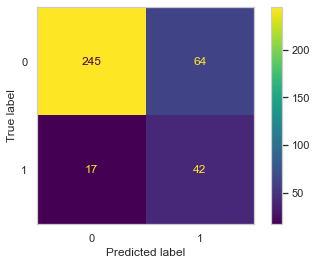

In [138]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(model_brf_clf, X_test, y_test)

## 8.7 Saving the model

In [139]:
# saves the model
pickle.dump(model_brf_clf, open('model/model_people_analytics.pkl', 'wb'))

# 9.0 Error translation and interpretation

## 9.1 Main metrics

In [140]:
# metrics
brf_dict = {'model': ['Balanced Random Forest Clf', '---'],
           'accuracy': [brf_accuracy, np.nan],
           'F1-Score': [brf_f1, np.nan],
           'PR AUC': [brf_auc, np.nan]}

df_performance_brf = pd.DataFrame(brf_dict)

df_performance_brf.drop(1)

,model,accuracy,F1-Score,PR AUC
0,Balanced Random Forest Clf,0.779891,0.509091,0.405141


As we are dealing with imbalaced data set, the most relevant metric, in this case, is the **F1-Score** (`0.509091`) which is used **when the False Negatives and False Positives are crucial**. For this project, False Negatives are crucial, since losing these people could lead to company financial loss.

## 9.2 PR AUC & Heatmap

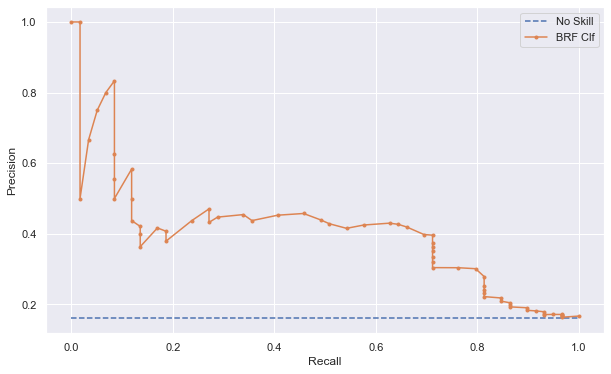

In [141]:
# sets seaborn default style
sns.set()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(10, 6)

# plots PR AUC
plot_pr_auc(y_test, brf_probs, 'BRF Clf')

# display plots
plt.show()

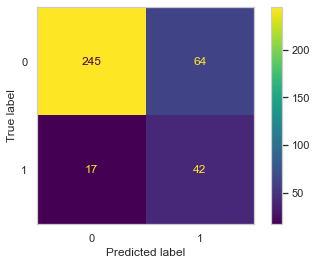

In [142]:
# set style to get rid of the grid lines
sns.set_style("whitegrid", {'axes.grid' : False})

_ = plot_confusion_matrix(model_brf_clf, X_test, y_test)

Let's recap the confusion matrix template and the best-worst scenario from **section 1.2**.

<img src="img/confusion-matrix.png" width="70%">

In addition, we can outline a **best-worst scenario** for an employee who leaves a company.

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Cost \($\)**                   | 4,000         | 7,645          |
| **Time to fill a position \(days\)** | 42        | 52             |

Our model was able to correctly identify 42 and miss 17 from a total of 59 employees who tend to leave. Translating to the best-worst scenario, this means:

|                                  | Best scenario | Worst scenario |
|----------------------------------|---------------|----------------|
| **Total loss saved \($\)**       | 168,000       | 321,090        |
| **Total time saved \(days\)**    | 1,764         | 2,184          |


In addition, **without the model**, the company would have 59 employees that could leave, translating it to **a total loss of \\$ 236,000 in the best scenario and \\$ 451,055 in the worst scenario**.

## 9.3 Classification report

In [143]:
print(classification_report(y_test, yhat_brf_clf))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       309
           1       0.40      0.71      0.51        59

    accuracy                           0.78       368
   macro avg       0.67      0.75      0.68       368
weighted avg       0.85      0.78      0.80       368



Observing the classification report, we can say:

- When the model predicted for `0` (don't tend to leave) it was 94% right most of the times.
- When the model predicted for `1` (tend to leave) it was 40% right most of the times.
- When the class was actually `0` (don't tend to leave) the model was 79% right most of the times.
- When the class was actually `1` (tend to leave) the model was 71% right most of the times.

## 9.4 Probability distribution

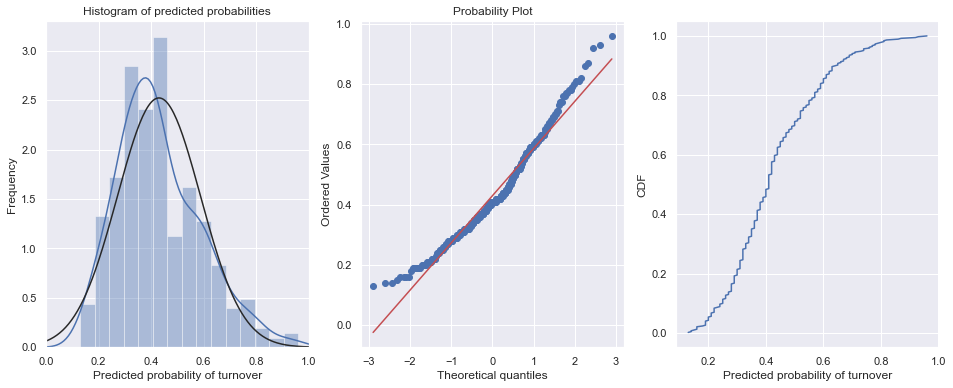

In [144]:
# sets seaborn default style
sns.set()

# store the predicted probabilities for class 1
y_pred_prob = model_brf_clf.predict_proba(X_test)[:, 1]

# set axes
fig, ax = plt.subplots()

# set fig size
ax.figure.set_size_inches(16, 6)

# plot histogram
plt.subplot(1, 3, 1)
ax = sns.distplot(y_pred_prob, fit=norm)


# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of turnover')
plt.ylabel('Frequency')

# plot probability
plt.subplot(1, 3, 2)
ax = stats.probplot(y_pred_prob, plot=plt)


# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(y_pred_prob)

# Plot the CDFs and show the plot
plt.subplot(1, 3, 3)
plt.plot(x_theor, y_theor)

plt.xlabel('Predicted probability of turnover')
plt.ylabel('CDF')

# displays the plot
plt.show()

Here, we are evaluating how normally distributed are the probabilities predicted by our model.

- **Histogram of predicted probabilities:** it nearly follows a normal distribution. The normal distribution is depicted in black-line bell shaped curve.

- **Probability Plot:** when can observe that almost all the points are or on the red diagonal line or close to it, which means that the probability distribution is near normal.

- **ECDF plot:** the cumulative distribution function almost follows the half of a normal distribution, which means that the probability distribution is near normal.

All these 3 elements show that the model is able to make good predictions, of course, it can always be improved.

# 10.0 Testing the predictions

## 10.1 False Negatives & True Positives

In [145]:
df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)
df_y_pred = pd.DataFrame(yhat_brf_clf)

df_y_test.columns = ['y_test']
df_y_pred.columns = ['y_pred']

df_test_final = pd.concat([df_y_pred, df_y_test, df_X_test], axis=1)

In [146]:
# false negatives or true postives
df_fn_tp = df_test_final[((df_test_final['y_pred'] == 0) & (df_test_final['y_test'] == 1)) | ((df_test_final['y_pred'] == 1) & (df_test_final['y_test'] == 1))]
df_fn_tp

,y_pred,y_test,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
10,1,1,0.023810,0.226915,0.714286,0.50,1.000000,0.100000,0.333333,0.00,0.333333,0.058557,0.315318,0.111111,1.0,0.142857,0.0,0.333333,0.000000,0.025,0.500000,1.000000,0.025,0.000000,0.000000,0.000000,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
12,1,1,0.333333,0.295634,0.000000,0.50,1.000000,0.457143,0.333333,0.00,0.666667,0.143286,0.300221,0.000000,1.0,0.214286,0.0,1.000000,0.000000,0.100,0.333333,0.000000,0.075,0.111111,0.066667,0.117647,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26,0,1,0.904762,0.242663,0.464286,0.75,0.333333,0.600000,0.666667,0.00,0.333333,0.208215,0.097009,1.000000,1.0,0.500000,0.0,0.000000,1.000000,0.175,0.333333,0.666667,0.125,0.222222,0.266667,0.176471,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
28,1,1,0.071429,0.468146,0.000000,0.00,0.000000,0.985714,0.333333,0.00,0.333333,0.061348,0.283317,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.075,0.500000,0.666667,0.075,0.111111,0.066667,0.117647,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
53,0,1,0.952381,0.032212,0.785714,0.75,1.000000,0.914286,0.666667,0.50,1.000000,0.489889,0.055049,0.111111,0.0,0.071429,0.0,1.000000,0.333333,1.000,0.500000,0.333333,1.000,0.555556,1.000000,0.352941,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
59,0,1,0.619048,0.911954,0.000000,0.25,0.333333,0.871429,0.333333,0.50,0.000000,0.498841,0.009315,1.000000,0.0,0.214286,0.0,1.000000,0.333333,0.600,0.166667,0.666667,0.500,0.333333,0.200000,0.352941,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
62,1,1,0.428571,0.969220,0.428571,1.00,0.333333,0.942857,0.333333,0.25,0.000000,0.269879,0.263562,0.555556,1.0,0.142857,0.0,0.333333,1.000000,0.400,0.500000,0.666667,0.050,0.111111,0.133333,0.117647,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
64,1,1,0.309524,0.166786,0.285714,0.25,0.666667,0.228571,0.333333,0.00,0.000000,0.069089,0.330375,0.000000,1.0,0.785714,1.0,0.000000,0.000000,0.100,0.000000,0.666667,0.075,0.111111,0.066667,0.117647,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
68,1,1,0.261905,0.171081,0.000000,0.50,0.333333,0.257143,0.333333,0.00,0.666667,0.094313,0.860389,0.666667,1.0,0.571429,0.0,0.666667,1.000000,0.125,0.500000,0.666667,0.075,0.111111,0.000000,0.117647,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
69,1,1,0.190476,0.585540,0.678571,0.25,1.000000,0.557143,0.666667,0.00,0.333333,0.059979,0.192532,0.000000,1.0,0.000000,0.0,0.666667,0.000000,0.150,0.500000,0.666667,0.125,0.055556,0.066667,0.235294,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 10.2 Putting all together in the original data set

In [147]:
# concatenates predictions with test data
df_final_data = pd.concat([df_y_pred, pd.DataFrame(X_test_e)], axis=1)

# filters the ones who tend to leave 
df_tend_to_leave = df_final_data[(df_final_data['y_pred'] == 1)]

# renames column
df_tend_to_leave.rename(columns={0: 'employee_id'}, inplace=True)

# filters original data set to check more info about the employee
filter_employees = df_employee['employee_number'].isin(set(df_tend_to_leave['employee_id']))
df_to_contact = df_employee[filter_employees]

/Users/brunokatekawa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# 11.0 Deploy model to production

## 11.1 Web application architecture

![](img/web-app-architecture.png)

## 11.1 People Analytics Class

In [148]:
import pickle
import inflection
import pandas as pd
import numpy as np

class PeopleAnalytics(object):
    def __init__(self):
        self.home_path = '/Users/brunokatekawa/Desktop/Projects/People_Analytics/'

        # loads the rescaling
        self.numerical_vars_scaler = pickle.load(open(self.home_path + 'parameter/numerical_vars_scaler.pkl', 'rb'))

        # loads the encoder
        self.categorical_vars_scaler = pickle.load(open(self.home_path + 'parameter/categorical_vars_scaler.pkl', 'rb'))


    def data_cleaning(self, df1):
        # 2.2 RENAMING COLUMNS

        # stores the old column names
        cols_old = ['Age', 'BusinessTravel', 'DailyRate', 'Department',
                    'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
                    'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
                    'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
                    'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
                    'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
                    'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
                    'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
                    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                    'YearsWithCurrManager']

        # snake case
        snakecase = lambda x: inflection.underscore(x)

        # creates new columns from old columns in snakecase
        cols_new = list(map(snakecase, cols_old))

        # renames the old columns
        df1.columns = cols_new

        return df1


    def feature_engineering(self, df2):
        # 3.3 COLUMN FILTERING
        # cols to drop
        cols_drop = ['over18', 'standard_hours', 'employee_count', 'employee_number']

        # drops the columns
        df2 = df2.drop(cols_drop, axis=1)

        return df2


    def data_preparation(self, df3):
        # Label Encoding
        # over_time
        df3['over_time'] = df3['over_time'].apply(lambda x: 1 if x == 'Yes' else 0)

        # RESCALING
        # selects only numerical data types variables
        df_numerical_vars = df3.select_dtypes(include=['int64'])

        # scales numerical vars
        scaled_numerical = self.numerical_vars_scaler.fit_transform(df_numerical_vars)

        # gets the Data Frame version of numerical scaled for later manipulation
        df_scaled_numerical = pd.DataFrame(scaled_numerical)

        # renaming the columns of result Data Frame
        df_scaled_numerical.columns = df_numerical_vars.columns


        # ENCODING
        # selects only categorical data types variables
        df_categorical_vars = df3.select_dtypes(include=['object'])

        # One Hot Encoding
        encoded_categorical = self.categorical_vars_scaler.fit_transform(df_categorical_vars.drop('business_travel', axis=1)).toarray()

        # convert do DataFrame
        df_encoded_categorical = pd.DataFrame(encoded_categorical)

        
        # Ordinal Encoding - as there is an order
        # explicitly dictates the encoding codes
        assortment_dict = {'Non-Travel': 1, 'Travel_Rarely': 2, 'Travel_Frequently': 3}
        
        # extracts the column
        business_travel = df_categorical_vars['business_travel']

        # maps the values from the dict and converts to DataFrame for later manipulation
        df_business_travel = pd.DataFrame(business_travel.map(assortment_dict))


        # joins all categorical
        df_encoded_all_categorical = pd.concat([df_business_travel, df_encoded_categorical], axis=1)

        # joins scaled and encoded explain vars
        df3 = pd.concat([df_scaled_numerical, df_encoded_all_categorical], axis=1)

        return df3

    def get_prediction(self, model, original_data, test_data):
        # predicts
        pred = model.predict(test_data.values)

        employee_number = original_data['employee_number'].reset_index().drop('index', axis=1)

        # creates new column for comparison
        test_data['employee_number'] = employee_number['employee_number']

        # creates y_pred column
        test_data['y_pred'] = pred

        # filters the ones who tend to leave 
        df_tend_to_leave = test_data[(test_data['y_pred'] == 1)]

        # filters original data set to check more info about the employee
        filter_employees = original_data['employee_number'].isin(set(df_tend_to_leave['employee_number']))
        df_to_contact = original_data[filter_employees]

        return df_to_contact


## 11.2 Test on simulated production environment

In [149]:
original_data = pd.read_csv('data/test_data.csv')

In [150]:
# instantiates PeopleAnalytics class
pipeline = PeopleAnalytics()

# data cleaning
df1_test= pipeline.data_cleaning(original_data)

# feature engineerin
df2_test = pipeline.feature_engineering(df1_test)

# data preparation
test_data = pipeline.data_preparation(df2_test)

# prediction
# df_response = pipeline.get_prediction(model, data, df3)

In [151]:
test_data.values

array([[0.23809524, 0.54558507, 0.14285714, ..., 0.        , 0.        ,
        1.        ],
       [0.83333333, 0.70208184, 0.42857143, ..., 1.        , 0.        ,
        0.        ],
       [0.14285714, 0.09619526, 0.75      , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.52380952, 0.85714286, 0.82142857, ..., 1.        , 0.        ,
        0.        ],
       [0.16666667, 0.14572864, 0.03571429, ..., 0.        , 1.        ,
        0.        ],
       [0.69047619, 0.76310122, 0.46428571, ..., 0.        , 1.        ,
        0.        ]])

In [152]:
# loads model
model = pickle.load(open('/Users/brunokatekawa/Desktop/Projects/People_Analytics/model/model_people_analytics.pkl', 'rb'))

pred = model.predict(test_data.values)

In [153]:
employee_number = original_data['employee_number'].reset_index().drop('index', axis=1)

In [154]:
# creates new column for comparison
test_data['employee_number'] = employee_number['employee_number']

# creates y_pred column
test_data['y_pred'] = pred

In [155]:
# filters the ones who tend to leave 
df_tend_to_leave = test_data[(test_data['y_pred'] == 1)]

In [156]:
# filters original data set to check more info about the employee
filter_employees = original_data['employee_number'].isin(set(df_tend_to_leave['employee_number']))
df_to_contact = original_data[filter_employees]
df_to_contact

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
2,24,Travel_Rarely,240,Human Resources,22,1,Human Resources,1,1714,4,Male,58,1,1,Human Resources,3,Married,1555,11585,1,Y,No,11,3,3,80,1,1,2,3,1,0,0,0
9,35,Travel_Rarely,1229,Research & Development,8,1,Life Sciences,1,63,4,Male,36,4,1,Laboratory Technician,4,Married,2269,4892,1,Y,No,19,3,4,80,0,1,2,3,1,0,0,1
10,47,Travel_Rarely,1454,Sales,2,4,Life Sciences,1,925,4,Female,65,2,1,Sales Representative,4,Single,3294,13137,1,Y,Yes,18,3,1,80,0,3,3,2,3,2,1,2
16,29,Travel_Frequently,461,Research & Development,1,3,Life Sciences,1,1753,4,Male,70,4,2,Healthcare Representative,3,Single,6294,23060,8,Y,Yes,12,3,4,80,0,10,5,4,3,2,0,2
17,36,Travel_Rarely,885,Research & Development,16,4,Life Sciences,1,1042,3,Female,43,4,1,Laboratory Technician,1,Single,2743,8269,1,Y,No,16,3,3,80,0,18,1,3,17,13,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,20,Travel_Rarely,1141,Sales,2,3,Medical,1,1657,3,Female,31,3,1,Sales Representative,3,Single,2783,13251,1,Y,No,19,3,1,80,0,2,3,3,2,2,2,2
361,26,Travel_Frequently,426,Human Resources,17,4,Life Sciences,1,608,2,Female,58,3,1,Human Resources,3,Divorced,2741,22808,0,Y,Yes,11,3,2,80,1,8,2,2,7,7,1,0
362,47,Travel_Frequently,719,Sales,27,2,Life Sciences,1,785,2,Female,77,4,2,Sales Executive,3,Single,6397,10339,4,Y,Yes,12,3,4,80,0,8,2,3,5,4,1,3
363,26,Travel_Frequently,575,Research & Development,1,2,Life Sciences,1,792,1,Female,71,1,1,Laboratory Technician,4,Divorced,4364,5288,3,Y,No,14,3,1,80,1,5,2,3,2,2,2,0


# Reference links

https://business.linkedin.com/talent-solutions/blog/employee-retention/2019/gallup-suggests-employee-turnover-in-us-business-is-1-trillion-dollar-problem-with-simple-fix

https://www.gallup.com/workplace/247391/fixable-problem-costs-businesses-trillion.aspx

https://www.gallup.com/workplace/260564/heard-quit-rate-win-war-talent.aspx

https://toggl.com/blog/cost-of-hiring-an-employee